# Intelligent Document Data Extraction and Analytics Agent
**Capstone Project for 5-Day Gen AI Intensive Course with Google**

## Business Problem
This capstone project focuses on developing an intelligent system for data extraction from PDF documents, enhanced by an agent capable of executing Python code for advanced analysis and processing. The project aims to address the challenges of efficiently retrieving both unstructured (text) and structured (tables) information from PDF files, and leveraging programmatic capabilities to gain deeper insights from the extracted data.

In industries such as financial services, a significant amount of historical data remains locked in unstructured formats like PDFs. These documents often contain a mix of text, images, and tables. Unlocking this data can provide organizations with richer analytical insights. Once extracted, the data can be queried using natural language through Retrieval-Augmented Generation (RAG). By integrating this with an agent capable of generating and executing Python code, the system can perform advanced analyses on the structured data, delivering deeper, more actionable insights. The first figure belows show the data extraction and storage into a vector and relational database. The second figure shows the querying capabilities using RAG and an analytics agent.

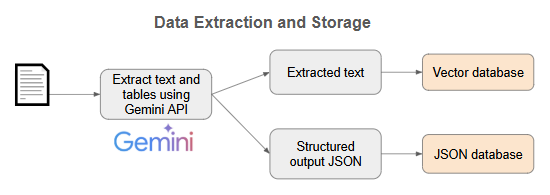

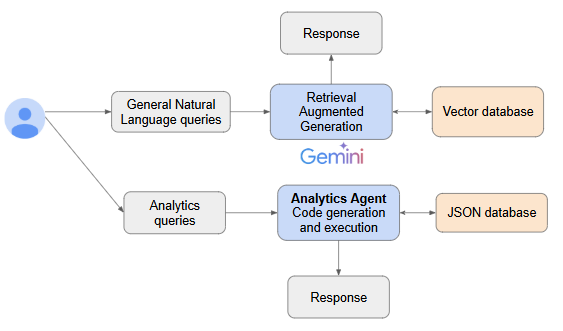

# Environment Configuration and Dependencies

In [2]:
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy jupyterlab jupyterlab-lsp kfp

# Install langgraph and the packages used in this lab.
# !pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'
!pip install -U -q "google-genai==1.7.0"  "chromadb==0.6.3"
!pip install langchain langchain-community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 65.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 86.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 k

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/documents/PC_Insurers_Filings.pdf
/kaggle/input/documents/Principal-Sample-Life-Insurance-Policy.pdf
/kaggle/input/documents/Shelter_HO-4Renters.pdf
/kaggle/input/documents/allstate_filing.pdf


In [4]:
# Import libraries
import os
from kaggle_secrets import UserSecretsClient
from google import genai
from google.genai import types

from typing import Annotated
from typing_extensions import TypedDict

# from langgraph.graph.message import add_messages
import pathlib
import httpx



print(genai.__version__)

1.7.0


In [5]:
# Setting up Google API key

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [6]:
# Automated Retry
# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

In [7]:
client = genai.Client(api_key=GOOGLE_API_KEY)

for m in client.models.list():
    if "embedContent" in m.supported_actions:
        print(m.name)

models/embedding-001
models/text-embedding-004
models/gemini-embedding-exp-03-07
models/gemini-embedding-exp


In [8]:
for model in client.models.list():
  print(model.name)

models/chat-bison-001
models/text-bison-001
models/embedding-gecko-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/gemini-2.5-pro-exp-03-25
models/gemini-2.5-pro-preview-03-25
models/gemini-2.5-flash-preview-04-17
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
models/gemini-2.0-flash-thinking-exp-01-21
mod

# Data Extraction from Documents

This section extracts text and tables from PDF documents using Gemini API. Gemini models can process large PDFs with native vision. I am using the document understanding secion of [Google docs](https://ai.google.dev/gemini-api/docs/document-processing?lang=python)

Future enhancements:
- Current completion is getting truncated because it exceeds the max output tokens. Consider extracting information by page.

In [9]:
folder = pathlib.Path("/kaggle/input/documents/")
files = [f for f in folder.iterdir() if f.is_file()]
filepath = pathlib.Path("/kaggle/input/documents/Shelter_HO-4Renters.pdf")

In [10]:
prompt_data_extraction = "Extract all the data of this PDF extactly as is, by preserving all original information."
def extract_data_from_pdf(filepath):
    prompt = prompt_data_extraction
    response = client.models.generate_content(
      model="gemini-2.0-flash",
        config =     types.GenerateContentConfig(
            temperature=0,
            max_output_tokens = 10**6
        ),
      contents=[
          types.Part.from_bytes(
            data=filepath.read_bytes(),
            mime_type='application/pdf',
          ),
          prompt])
    return response

In [11]:
# response = client.models.generate_content(
#     model="gemini-2.0-flash",
#     contents="Explain AI to me like I'm a kid.")

response = extract_data_from_pdf(filepath)
print(response.text)

Here's the OCR extracted text from the PDF, preserving all original information:

HOMEOWNERS'
INSURANCE
POLICY
For information regarding this policy, please
contact your Shelter Insurance Agent.
TO OUR CUSTOMERS – PLEASE NOTE
Please read this policy carefully. If you have
questions, contact your Shelter Agent for answers.
No agent can know your exact coverage needs or
budget considerations, so it is your responsibility to
examine the policy and make sure it provides the
types of coverage you need in the amounts you
requested.
If you suffer a loss, please read this policy again so
that you will be reminded of your rights and
obligations. It is very important for you to recognize
that this insurance policy is a legally binding
contract. If any insured fails to perform an
obligation required by this policy, the coverage
which it might otherwise provide could be lost.
HO-4
(01-07)
SHELTER
INSURANCE
SHELTER INSURANCE COMPANIES
Home Office: Columbia, MO 65218-0001
THE INDEX
WHERE YOU CAN FIN

In [12]:
out = {}
for filepath in files:
    out[filepath.name.split('.')[0]] = extract_data_from_pdf(filepath)

In [61]:
def extract_data_from_pdf_table(filepath):
    prompt_data_extraction = "Extract the first 5 tables of this PDF. Return response in JSON format."
    prompt = prompt_data_extraction
    response = client.models.generate_content(
      model="gemini-2.0-flash",
        config =  types.GenerateContentConfig(
            # temperature=0,
            # max_output_tokens = 10**9,
            response_mime_type="application/json"
        ),
      contents=[
          types.Part.from_bytes(
            data=filepath.read_bytes(),
            mime_type='application/pdf',
          ),
          prompt])
    return response

In [62]:
filepath = pathlib.Path("/kaggle/input/documents/Travelers-2024-Annual-Report.pdf")
response = extract_data_from_pdf_table(filepath)

In [28]:
print(response.text)

[
  {
    "table_number": 1,
    "content": [
      [
        "Location",
        "% of Total"
      ],
      [
        "Domestic:",
        ""
      ],
      [
        "California",
        "10.5%"
      ],
      [
        "Texas (1)",
        "9.0"
      ],
      [
        "New York",
        "8.2"
      ],
      [
        "Florida",
        "4.1"
      ],
      [
        "Pennsylvania",
        "4.1"
      ],
      [
        "Illinois",
        "3.7"
      ],
      [
        "Georgia",
        "3.6"
      ],
      [
        "New Jersey",
        "3.6"
      ],
      [
        "Massachusetts",
        "3.1"
      ],
      [
        "All other domestic (2)",
        "45.0"
      ],
      [
        "Total Domestic",
        "94.9"
      ],
      [
        "International:",
        ""
      ],
      [
        "Canada",
        "2.8"
      ],
      [
        "All other international",
        "2.3"
      ],
      [
        "Total International",
        "5.1"
      ],
      [
        "Co

In [33]:
import json
import pandas as pd

In [65]:
json.loads(response.text)[0]

{'table_number': 1,
 'columns': ['Location', '% of Total'],
 'rows': [{'Location': 'Domestic:', '% of Total': None},
  {'Location': 'California', '% of Total': '10.5%'},
  {'Location': 'Texas (1)', '% of Total': '9.0'},
  {'Location': 'New York', '% of Total': '8.2'},
  {'Location': 'Florida', '% of Total': '4.1'},
  {'Location': 'Pennsylvania.', '% of Total': '4.1'},
  {'Location': 'Illinois', '% of Total': '3.7'},
  {'Location': 'Georgia', '% of Total': '3.6'},
  {'Location': 'New Jersey', '% of Total': '3.6'},
  {'Location': 'Massachusetts', '% of Total': '3.1'},
  {'Location': 'All other domestic (2)', '% of Total': '45.0'},
  {'Location': 'Total Domestic', '% of Total': '94.9'},
  {'Location': 'International:', '% of Total': None},
  {'Location': 'Canada', '% of Total': '2.8'},
  {'Location': 'All other international', '% of Total': '2.3'},
  {'Location': 'Total International', '% of Total': '5.1'},
  {'Location': 'Consolidated total', '% of Total': '100.0%'}],
 'notes': [{'note_n

# Data Storage

## Vector Databases

In [97]:
from chromadb import Documents, EmbeddingFunction, Embeddings
from google.api_core import retry

from google.genai import types


# Define a helper to retry when per-minute quota is reached.
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})


class GeminiEmbeddingFunction(EmbeddingFunction):
    # Specify whether to generate embeddings for documents, or queries
    document_mode = True

    @retry.Retry(predicate=is_retriable)
    def __call__(self, input: Documents) -> Embeddings:
        if self.document_mode:
            embedding_task = "retrieval_document"
        else:
            embedding_task = "retrieval_query"

        response = client.models.embed_content(
            model="models/text-embedding-004",
            contents=input,
            config=types.EmbedContentConfig(
                task_type=embedding_task,
            ),
        )
        return [e.values for e in response.embeddings]

In [99]:
out.keys()

dict_keys(['PC_Insurers_Filings', 'Principal-Sample-Life-Insurance-Policy', 'Shelter_HO-4Renters', 'allstate_filing'])

In [104]:
[el.text for el in out.values()]

['Here is the data from the PDF, extracted exactly as it is, preserving all original information:\n\nCOMPANY NAME\nPROPERTY AND CASUALTY INSURERS FILING ON THE HEALTH BLANK\nCONTACT\nREQUIRED FILINGS IN THE STATE OF: WISCONSIN\nNAIC COMPANY CODE\nPHONE\nFilings Made During the Year 2025\n(1) (2)\n(4)\n(5)\n(6)\n(7)\n(8)\nCheck- Line\nNUMBER OF COPIES*\nDomestic\nForeign\nlist\n#\nREQUIRED FILINGS FOR THE ABOVE STATE\nDUE DATE\nFORM\nSOURCE**\nPORTAL NAME\nAPPLICABLE\nNOTES\nState NAIC State\nI. NAIC FINANCIAL STATEMENTS\n1\nAnnual Statement (8.5"x14")\nEO\nEO\nXXX\n3/1\nNAIC\nFinancial Statement\nA-M, S, AA,\nAU\n1.1\n2\nPrinted Investment Schedule detail (pages E01-E29)\nQuarterly Financial Statement (8.5"x14")\nEO\nEO\nXXX\n3/1\nNAIC\nFinancial Statement\nAU\nEO\nEO\nXXX 5/15, 8/15, 11/15 NAIC\nFinancial Statement\nΟ\nII. NAIC SUPPLEMENTS\n11\n12\nAccident & Health Policy Experience Exhibit\nActuarial Opinion\nEO\nEO\nXXX 4/1\nNAIC\nAnnual Supplement\nM\nEO\nEO\nN/A 3/1\nCompany\nAct

In [105]:
import chromadb

DB_NAME = "googlecardb"

embed_fn = GeminiEmbeddingFunction()
embed_fn.document_mode = True

chroma_client = chromadb.Client()
db = chroma_client.get_or_create_collection(name=DB_NAME, embedding_function=embed_fn)

db.add(documents=[el.text for el in out.values()], ids=list(out.keys()))

In [106]:
db.count()


4

# Querying Data

## Natural Languange

In [107]:
# Switch to query mode when generating embeddings.
embed_fn.document_mode = False

# Search the Chroma DB using the specified query.
query = "What is the definition of land motor vehicle?"

result = db.query(query_texts=[query], n_results=1)
[all_passages] = result["documents"]

Markdown(all_passages[0])

Here's the OCR extracted text from the PDF, preserving all original information:

HOMEOWNERS'
INSURANCE
POLICY
For information regarding this policy, please
contact your Shelter Insurance Agent.
TO OUR CUSTOMERS – PLEASE NOTE
Please read this policy carefully. If you have
questions, contact your Shelter Agent for answers.
No agent can know your exact coverage needs or
budget considerations, so it is your responsibility to
examine the policy and make sure it provides the
types of coverage you need in the amounts you
requested.
If you suffer a loss, please read this policy again so
that you will be reminded of your rights and
obligations. It is very important for you to recognize
that this insurance policy is a legally binding
contract. If any insured fails to perform an
obligation required by this policy, the coverage
which it might otherwise provide could be lost.
HO-4
(01-07)
SHELTER
INSURANCE
SHELTER INSURANCE COMPANIES
Home Office: Columbia, MO 65218-0001
THE INDEX
WHERE YOU CAN FIND IT
Declarations - Your Name, Location of Your Residence, Policy Period, Limits of Liability and Deductibles
Beginning on Page
Agreement
2
Definitions
2
General Agreements applicable to entire policy
8
Section I - Property Protection
10
Coverage C - Personal Property
10
Coverage D - Additional Living Expense and Loss of Rents
16
Additional Coverages Under Section I
16
Special Provisions and Conditions Relating To Section I
18
Section II - Personal Liability and Medical Payment Protection
22
Coverage E - Personal Liability
22
Coverage F - Medical Payments To Others
24
Coverage G - Damage to Property of Others
26
Additional Coverages Under Section II
27
HO-4 (01-07)
1
HOMEOWNERS' INSURANCE POLICY
CONTENTS BROAD COVERAGE FORM 4
AGREEMENT
We agree to insure you according to all the terms of this policy,
(1) in reliance on your statements in the Application and in any Application for Change, both of which are made
a part of this policy, and
(2) based on our receipt of your payment of the premium.
When we receive your premium, this policy provides the types of insurance, in the limited amount, shown in the
Declarations. If any premium payment is by check, no insurance is provided if the bank does not honor the
check.
DEFINITIONS USED THROUGHOUT THIS POLICY
In this policy, the words shown in bold type have the meanings stated below unless a different meaning is stated
in a particular coverage or endorsement. Words in bold type that are derived from a defined word have the same
root meaning. The plural version of a defined word has the same meaning as the singular if it is bolded. If any of
these same words are used but not printed in bold type, they have the meaning given them by their common
usage as set out in commonly used dictionaries.
1. Accident means an action or occurrence, or a
series of actions or occurrences, that:
(a) started abruptly,
(b) during the policy period, and
(c) directly resulted in bodily injury or property
damage.
If an action or occurrence that started abruptly
continues over a period of time and ultimately
results in bodily injury or property damage that
cannot be definitely attributed to any one specific
action or occurrence, all such bodily injury or
property damage is, under this policy definition,
only one accident. If a series of abrupt actions
or occurrences ultimately results in bodily injury
or property damage that cannot be definitely
attributed to any one specific action or
occurrence, all such actions and occurrences,
under this policy definition, constitute only one
accident.
Accident does not mean:
(a) an action or occurrence that any insured
intended to result in bodily injury, or
property damage, of any type;
(b) an action or occurrence that is intended by
HO-4 (01-07)
2
any insured, if a reasonable individual
would expect it to result in bodily injury, or
property damage, of any type; or
(c) an intentional action by any person that
does not immediately result in bodily injury
or property damage, but ultimately does
result in such because of its repetition or the
repetition of similar actions.
2. Accidental direct physical loss means loss of
possession of, or actual physical damage to, a
part of the covered property which is caused by
an accident. It does not include:
(a) consequential economic damage resulting
from such physical damage to that part or
to the covered property as a whole,
(b) consequential economic damage resulting
from the inability to restore full monetary
value to that part or to the covered property
as a whole because of the fact that it has
sustained physical damage,
(c) consequential economic damage resulting
from the loss of use of that part or the
covered property as a whole,
(d) consequential economic damage resulting
from the inability to match the parts which
are repaired or replaced with undamaged
adjacent parts, or
(e) any diminution of the pre-loss value of the
covered property after the repair or
replacement of its parts.
3. Actual cash value means total restoration cost
less depreciation. If the law of the state in which
this policy is issued limits the factors which may
be considered in determining the actual cash
value, only the factors allowed by such law will
be considered.
4. Bodily injury means:
(a) a physical injury;
(b) a sickness or disease of the body;
(c) the physical pain and physical suffering
which directly results from (a) or (b), above;
and
(d) a death which directly results from (a) or
(b), above.
Bodily injury does not mean:
(a) a mental injury;
(b) a sickness or disease of the mind;
(c) mental anguish; or
(d) emotional distress;
unless such mental or emotional condition is
diagnosed by a medical doctor and directly
results from bodily injury to the individual on
whose behalf the claim is made.
5. Business means any activity for which the
person engaged in that activity receives
compensation of any kind, or reasonably expects
to receive compensation of any kind. Business
does not mean:
(a) the occasional sale of personal property at
the residence premises unless that
property was raised, grown, or acquired, for
the purpose of selling it;
(b) the occasional rental or leasing, or the
holding for rental or leasing, of the
dwelling on the residence premises in
which you reside, for use as a dwelling;
(c) the rental or leasing, or the holding for
rental or leasing, of a part of the dwelling
on the residence premises in which you
HO-4 (01-07)
3
reside, for use as a dwelling, unless the
rental or lease is to three or more roomers
or boarders;
(d) a part-time activity, engaged in by you or a
relative, if the individual engaged in that
activity is under the age of twenty-five, and
is a full time student.
6. Claim means a request by any person for
benefits under this policy as a result of any one
accident. It includes lawsuits, requests for the
payment of money and requests that we take any
action, or extend any coverage, provided for by
this policy.
7. Compensation Law means any law under which
benefits are paid to a person as compensation
for the effects of bodily injury, without regard
to fault, because of that person's status as an
employee or beneficiary. It includes, but is not
limited to, workers' compensation laws, disability
laws, the Federal Employers' Liability Act and the
Jones Act.
8. Custom farming means the maintenance or use
of premises, other than insured premises, for
the production of farm products and includes all
operations reasonably necessary for such
production that are performed:
(a) at the request of the owner or renter of
those premises; and
(b) in exchange for compensation in the form
of money or goods.
Custom farming does not mean operations
performed as part of an exchange of farming
services so long as no other compensation is
paid.
9. Declarations means the part of this policy titled
“Homeowner's Insurance Policy Declarations". It
sets out many of the individual facts related to
your policy including the dates, types, and
amounts, of the various coverages.
10. Decorative fixture means wall covering, floor
covering, paint, and molding which is attached
to the interior of:
(a) your dwelling at the residence premises;
or
(b) other structures which are permanently
attached to the residence premises, but not
attached to your dwelling. If a structure is
connected to the dwelling by only a utility
line or fence, it will not be considered
attached to the dwelling for purposes of this
definition.
11. Deductible means an amount of money
deducted from the total amount of all losses
covered under Section I of this policy, unless the
specific coverage under which a loss is covered
says otherwise. The amount of your deductible
is shown in the Declarations or in the specific
policy provision under which a loss is covered.
12. Depreciation means an amount of money that
is deducted from the amount we actually pay.
That amount is based on the decrease in the
value of the property since it was new. It applies
to any part that must be repaired or replaced
to allow for the repair or replacement of a
damaged part, whether or not that part itself is
damaged. The condition, age, extent of use, and
obsolescence of the part, and the property as a
whole, will be considered in determining
depreciation. Depreciation also applies to the
labor and applicable sales tax necessary to
complete covered repairs and replacements.
We will calculate the percentage by which the
materials necessary to the replacement have
decreased in value, based on the factors stated
above, and apply that same percentage when
calculating the depreciation applicable to the
labor and sales tax.
13. Domestic appliance means a device operated by
mechanical power, fuel, or electric current, which
is customarily used inside a dwelling. Domestic
appliance does not include permanently
installed:
(a) heating systems;
(b) cooling systems;
(c) water heating systems; or
(d) water softeners.
14. Dwell means to live in a location with, or without,
the intent to make that place one's residence.
HO-4 (01-07)
4
15. Dwelling means the structure in which one
dwells.
16. Farming means the ownership, maintenance or
use of premises for the production of farm
products and includes all operations reasonably
necessary for such production. Farming does
not include the sale of farm products. Farming
does not include custom farming.
17. Farm products means:
(a) crops grown, raised, or kept, for the
purpose of commercial sale; and
(b) livestock grown, raised, or kept, for the
purpose of commercial sale.
18. General contractors' overhead and profit means
any amount of money included in, or added to,
the estimated, or actual, cost of restoring
damaged property, to compensate a contractor
for something other than:
(a) the materials actually installed in, or on, the
damaged property, or
(b) the labor and equipment necessary to install
such materials.
19. Individual means a human being.
20. Insured means:
(a) You;
(b) relatives;
(c) any other individual under the age of 21
residing in your household who is in your
care or the care of a relative;
(d) with respect to any vehicle covered by
this policy, any employee of a person
listed in (a), (b) or (c) above, while in the
course and scope of such employment;
and
(e) any person legally responsible for animals
or watercraft covered by this policy and
owned by a person listed in (a), (b) or (c)
above. But we will cover that person only
with respect to activities directly related to
those animals or watercraft. Insured does
not mean:
(1) any person using or having custody of
an animal or watercraft in the course of
any business; or
(2) any person having custody of an animal
or watercraft without permission of the
owner of that animal or watercraft.
21. Insured premises means:
(a) the residence premises;
(b) any one or two family dwelling you acquire
during the term of this policy, if you intend
to reside there during the term of this
policy;
(c) the part of any other premises where you
dwell if it is shown in the Declarations;
(d) the part of any premises that are not owned
by any insured, if an insured is temporarily
using it as a dwelling;
(e) the part of any structures or premises, not
owned by any insured, which an insured
occasionally rents for non-business
purposes;
(f) unimproved premises owned by, controlled
by, or rented to, an insured, but this does
not include premises, any part of which are
used for farming or custom farming;
(g) cemetery plots, or burial vaults, owned by
an insured;
(h) land on which a single or two family
dwelling is being built for an insured, if the
land is owned by, or rented to, the same
insured; or
(i) any structures used by you for storage of
non-business items usually kept on the
residence premises, and any premises to
which those structures are attached.
22. Judgment interest means interest on any
judgment provided for by the law of the state in
which the judgment is entered, whether it
accrues before or after a judgment.
23. Land motor vehicle means:
(a) a motorized vehicle originally designed
primarily for travel on public roadways;
(b) a motorized vehicle that is licensed for use
on public roadways; or
(c) a vehicle attached to, or carried on, another
vehicle that meets the definition set out in
(a) or (b), above.
HO-4 (01-07)
5
24. Lease means a right to possess and use real
property or personal property for a period of
thirty or more consecutive days based upon a
written agreement with the owner of that
property.
25. Market value means the price that the damaged
part of the covered property would have brought
immediately before the loss, if offered for sale
by a reasonable person who is willing, but not
obliged, to sell it, and bought by a reasonable
person who is desirous of purchasing it, but who
is not compelled to do so.
26. Motorized vehicle means any type of vehicle
capable of transporting one or more people that
has ever been powered by an internal
combustion engine regardless of the type of fuel
used in that engine. This definition applies even
if an engine is no longer used to power the
vehicle. This definition applies to all vehicles
whether they are designed to operate on land,
water, or in the air.
27. Named insured means any persons listed in the
Declarations under the heading “Named
Insured” and does not include persons listed
under other headings unless they are also listed
under the heading “Named Insured”.
28. Own means that the person referred to holds
the legally recognized title to, or is a
leaseholder of, an item of real property or
personal property, irrespective of the fact that
there may be other owners. This definition is
not changed by the patterns of usage of the
property.
29. Owner means any person who is a legally
recognized titleholder or leaseholder of an item
of real property or personal property,
irrespective of the fact that there may be other
titleholders or leaseholders. An owner's status
as such is not changed by the patterns of usage
of the property.
30. Person means an individual, a corporation, or
an entity, which has separate legal existence
under the laws of the state in which this policy
is issued.
31. Personal property means items that are not
permanently attached to premises. It includes
buildings on the residence premises that are not
permanently attached to the residence
premises. If an item or structure is attached to
something only by a utility line it will not be
considered permanently attached to it.
32. Premises means real estate. It includes land and
any improvements permanently attached to the
land. For purposes of this policy, all real estate
conveyed by one deed granting title to that land
will be considered the same premises. Lands
conveyed by separate deeds will be considered
separate premises.
33. Property damage means physical injury to or
destruction of tangible property and includes
damages for the loss of its use.
34. Public roadway means a roadway maintained by
a governmental entity or agency including its
adjacent right of ways. The fact that the general
public has access to a roadway does not itself
make that roadway a public roadway.
35. Punitive damages means a monetary award
imposed to punish a wrongdoer and to deter
others from similar conduct. It includes
exemplary damages. It also includes any
damages, or penalties, based upon any legal
theory that requires proof of the same standard
of conduct necessary to support an award of
punitive damages or exemplary damages, under
the law of the state in which they are awarded.
36. Recreational motor vehicle means a motorized
vehicle that:
(a) was not originally designed primarily for
travel on public roadways, or
(b) is not currently licensed for use on public
roadways.
Recreational motor vehicle does not mean:
(a) a vehicle used, or designed to be used, in
competition with other vehicles,
(b) a vehicle used solely to service the
residence premises, or
(c) a vehicle originally designed to assist the
physically handicapped, or
HO-4 (01-07)
6
(d) a lawnmower used solely to mow grass.
37. Relative means an individual related to you by
blood, marriage, or adoption, who is primarily a
resident of, and actually living in, your
household. It includes your unmarried and
unemancipated child away at school.
38. Rent means a right to possess and use real
property or personal property for a period of
less than thirty consecutive days based upon a
written agreement with the owner of that
property.
39. Repair means restoration by the use of labor
only on the damaged part of the covered
property in order to restore its form and function.
Restoration of pre-accident value is not included
in the definition of repair.
40. Replace means the installation or provision of
materials or parts to, or in place of, the
damaged part of the covered property. It
includes the installation or provision materials
or parts to, or in place of, any undamaged
parts that must be replaced to allow for
replacement of the damaged part. It also
includes the labor necessary to accomplish
such installation. Restoration of pre-accident
value is not included in the definition of
replace.
41. Reside means to live in a location with the intent
to make that place, and no other, one's
permanent home. If the parents of a minor child
do not reside with one another, we will consider
the child a resident of both their households if
that child regularly spends time in each of their
residences.
42. Residence employee means an employee of an
insured whose duties entail the maintenance or
use of the residence premises, or who performs
similar duties elsewhere but not in connection
with an insured's business.
43. Residence premises means:
(a) any one or two family dwelling situated on
the premises described in the Declarations
if:
(1) you own that dwelling; and
(2) you presently reside in that dwelling,
have resided there in the last thirty
days, or will reside there within thirty
days of the inception date of this policy;
or
(b) a one or two family dwelling referred to in
the Declarations as the “secondary
residence premises”, if you own that
dwelling at the time of a loss.
That dwelling, the grounds, and other structures
at the same premises, are included in this
definition.
44. Restoration cost means the amount of money
it will, or did, cost to restore the form and
function of the damaged part of covered property
by:
(a) replacing it; or
(b) repairing it,
whichever is less expensive.
Restoration cost can be based on a combination
of (a) and (b) above, if some parts of the covered
property are replaced and other parts are
repaired. Restoration cost includes:
(a) the cost of construction techniques
commonly used by the building trades in the
geographical area of the covered property;
and
(b) the cost of materials and parts, comparable
in quality to the damaged materials and
parts, to the extent those are available in the
geographical area of the covered property.
Restoration cost does not include:
(a) consequential economic damage resulting
from physical damage to the part or the
covered property as a whole,
(b) consequential economic damage resulting
from the inability to restore full monetary
value to the part or the covered property as
a whole because it has sustained physical
damage,
(c) consequential economic damage resulting
from the loss of use of the part or the
covered property as a whole,
(d) consequential economic damage resulting
from the inability to match the parts that are
repaired or replaced with undamaged
adjacent parts, except as provided in the
insuring agreement with respect to
decorative fixtures,
(e) any diminution of the pre-loss value of the
covered property after the repair or
replacement of its parts,
(f) the cost of replacing or repairing materials
or parts that are unavailable in the
geographic area of the covered property
with those of like quality,
(g) the cost of using the services of tradesmen
or craftsmen who do not regularly offer their
services in the geographic area of the
covered property, or
(h) general contractors' overhead and profit.
45. Total restoration cost means the restoration
cost of all of the damaged parts of the covered
property that were damaged in one accident.
46. Unoccupied means that people were not
residing in the residence premises at the time
of the loss.
47. Vacant means that you have ceased to dwell
there and that the dwelling is devoid of all
personal property except those items that you
intend to permanently leave at that location.
48. War means armed conflict whether or not
officially declared. It includes civil war,
insurrection, rebellion, revolution, or any act or
condition incident to any of those events.
49. We, us and our mean the Company providing
this insurance.
50. You means any person listed as a named
insured in the Declarations and, if that person
is an individual, his or her spouse.
HO-4 (01-07)
7
GENERAL AGREEMENTS APPLICABLE TO ENTIRE POLICY
1. WHAT TO DO IN CASE OF BODILY INJURY OR
PROPERTY DAMAGE
In the event of an accident covered under this
policy, the insured must promptly take all of the
following actions:
(a) Notify us or our agent as soon as possible.
The notice must give:
(1) your name and policy number;
(2) the time, place and circumstances of
the accident; and
(3) the names and addresses of all injured
individuals and witnesses.
(b) Cooperate with us, and assist us in any
matter relating to a claim.
(c) Send us all correspondence and all legal
papers that relate to any claim, made by
anyone, against us or against the person
seeking such coverage.
(d) Authorize us to obtain any other records that
may be relevant to the claim or may
reasonably be expected to aid our
investigators in determining the facts
relevant to the claim.
(e) Provide us with a list of the damaged
property if a loss covered under Damage to
Property of Others occurs. The insured
must also exhibit the damaged property to
us if it is within the insured's control.
(f) Provide any written proofs of loss we require.
(g) Answer, under oath, any questions posed by
us, and sign a written transcript of such
questions and answers.
If such claim is based upon bodily injury, the
person making such claim must also:
(h) submit to physical examinations, at our
expense, by doctors we select as often as
we may reasonably require;
(i) authorize us to obtain relevant medical
records of the individual whose bodily
injury is the basis for such claim.
The insured must not, except at his or her own
cost, voluntarily make any payment, assume any
HO-4 (01-07)
8
obligation, or incur any expenses related to the
bodily injury or property damage.
2. ASSIGNMENT
Except as provided in Coverage F of this policy,
you may not assign any of your rights and
interests under this policy, unless we consent to
such assignment, in writing and endorse that
change on this policy. Such endorsement will
then become a part of this policy.
3. COVERAGE IN THE EVENT OF YOUR DEATH
If you die, the provisions of this policy will apply
to:
(a) any surviving member of your household
who was covered under this policy at the
time of your death, but only while that
individual is a resident of, and actually
living in, the dwelling on the insured
premises;
(b) your legal representative while acting within
that capacity; and
(c) any person having proper custody of
insured property until a legal representative
is appointed.
However, in order to obtain this coverage, any
of the people listed in (a), (b) and (c), above,
must notify us of your death. Coverage under
this provision will be provided for a maximum
of thirty days after your death, and will terminate
if the policy lapses.
4. NOTICE TO US
Any notice required by this policy may be given
by, or on behalf of, the insured to our authorized
agent within this state. If that notice contains
sufficient information for us to identify the
insured, we will consider it notice to us.
5. LEGAL ACTION AGAINST US
Any person who makes a claim or seeks
coverage under this policy agrees not to institute
any legal action against us unless that person
has fully complied with all the terms of this
policy. Any legal action seeking a payment or a
determination of coverage under this policy or
its binder must be brought in the state in which
the residence premises are located. This policy
and its binder are to be interpreted in accordance
with the laws of the state in which the residence
premises are located.
6. CANCELLATION
Cancellation of this policy will be handled in
accordance with the state specific endorsement
attached to this policy.
7. REFUSAL TO RENEW
Refusal to renew this policy will be handled in
accordance with the state specific endorsement
attached to this policy.
8. CONCEALMENT OR FRAUD
This entire policy is void as to all insureds if any
insured has:
(a) intentionally concealed, or misrepresented,
any material fact or circumstance relating to
the purchase of this policy;
(b) negligently misrepresented any material fact
or circumstance related to the purchase of
this policy;
(c) intentionally concealed or misrepresented
any material fact related to any claim made
under this policy; or
(d) acted fraudulently, or made false statements,
relating to any claim made under this policy.
9. CHANGES TO THE POLICY
This policy includes the printed policy form, its
endorsements, the application related to it, any
applications for changes to it, and the
Declarations. Those documents constitute all
the agreements between you and us relating to
this insurance. No change or waiver may be
effected in this policy except by written
endorsement issued by us. If a premium
adjustment is necessary we will make the
adjustment as of the effective date of the change.
If we change this particular policy form so the
insurance it provides is broadened without extra
premium, this policy will be broadened as of the
date we make that change effective in your state,
and the broader form will apply to your claims
after that date.
HO-4 (01-07)
9
10. YOUR OBLIGATION TO NOTIFY US OF YOUR
CHANGES
The premium charged for this policy is based in
large part on information you provided to us. If that
information is incomplete or inaccurate, or if it
changes during the policy period, you must inform
us of that, if it relates to any of the following:
(a) a change in your residence;
(b) a change in the number or types of
businesses operated on the insured
premises;
(c) a change in the ownership or management
of any business operated on the insured
premises;
(d) a change in the number of occupants, who
are not relatives, residing at the insured
premises;
(e) an addition or upgrade in the insured
premises; or
(f) a change in the number or types of animals
kept on the insured premises.
11. OUR RIGHT TO INSPECT PREMISES
We have the right to inspect any premises
covered by this policy as often as may be
reasonable during the term of this policy. You
agree to allow us to come onto those premises
and into any buildings on those premises.
12. OUR RIGHT TO RECOVER PAYMENT
In the event we make any payment under this
policy, we will be subrogated to all rights of
recovery, based upon the same damages that an
insured, or any other person receiving the
payment, may have against any person liable for
those damages.
Any insured, or other person who receives
payment under this policy, agrees to execute and
deliver legal instruments to us, and to take any
reasonable actions necessary to secure our
rights if we ask.
Any insured, or other person who receives
payment under this policy, agrees to cooperate
with us in enforcing our rights of recovery
acquired under this section and to do nothing to
prejudice our rights.
This does not apply to the coverages headed
“Medical Payments to Others” and “Damage to
Property Of Others”.
13. POLICY COVERAGE PERIOD
This policy applies only to losses, bodily injury
or property damage that occur during the policy
period.
14. OTHER INSURANCE
If this policy and any other insurance, issued by
us, or by any other company, applies to the
same loss, this policy will apply as follows.
(a) With respect to all coverages contained in
Section I, the insurance provided by this
policy will be prorated, based upon the
applicable limits of each policy, up to the
highest limit provided by any one policy. This
does not apply if a mortgagee, or trustee
under a deed of trust, has duplicate coverage
because of the ten-day notice provision
contained in the section related to mortgagees
and trustees. In that instance, the provisions
of that section respecting the priority of
coverages will control.
(b) With respect to all coverages contained in
Section II, the insurance provided by this
policy will apply only as excess insurance,
and will then apply only in the amount by
which its limits exceed the limits of all such
other policies.
15. OTHER SOURCES OF COMPENSATION FOR THE
LOSS
(a) If an insured is entitled to receive full
compensation for a loss covered by this
policy from another source, this policy will
not apply to such loss.
(b) If an insured is entitled to receive partial
compensation for a loss covered by this
policy from another source, this policy will
apply only to the amount of the loss for
which the insured is not entitled to
compensation from that source.
16. CONFORMITY TO APPLICABLE LAWS
If the terms of this policy conflict with the laws
of any state that are applicable to a covered loss,
the conflicting terms are amended to conform to
such laws.
17. EFFECT OF POLICY ACCEPTANCE
By acceptance of this policy, you agree that the
statements in the Declarations and in any
Application or Application for Change accepted
by us, are offered as an inducement to us to
issue, continue, or renew this policy, and are
your agreements or representations. They are
not warranties.
18. CONTINUOUS RENEWAL
Subject to our consent and subject to the
premiums, rules and forms then in effect for us,
this policy may be continued in force by payment
of the required continuation premium for each
successive policy term. Such continuation
premium must be paid to us before the
expiration of the then current policy term and if
not paid the policy shall terminate.
With respect to any mortgagee (or trustee)
named in the Declarations, this insurance will
continue in force as to only the interest of the
mortgagee (or trustee) for 10 days after written
notice of termination to the mortgagee (or
trustee), and shall then terminate.
SECTION I PROPERTY PROTECTION
COVERAGE C-PERSONAL PROPERTY
INSURING AGREEMENT
We cover accidental direct physical loss to:
1. personal property owned or used by the
insured; and,
2. personal property you do not own if:
(a) it is located at the residence premises at
the time of the loss;
HO-4 (01-07)
(b) you have been at the residence premises
during the 45 days immediately preceding
the loss; and
(c) you ask us to provide this coverage for that
property.
These coverages apply only if the loss is caused by
one or more of the following perils, and it is not
10
excluded elsewhere in this coverage:
1. Fire or lightning.
This peril does not include loss caused by nuclear
reaction, radiation, radioactive contamination or
discharge of a nuclear weapon even if accidental,
or any consequence of any of these.
2. Wind or hail.
This peril does not include loss:
(a) to property in a building, caused by wind,
rain, snow, sand, sleet or dust unless the
building is first damaged by the direct force
of wind or hail, creating an opening through
which the wind, rain, snow, sand, sleet or
dust enters; or
(b) to watercraft and their trailers, furnishings,
equipment, and motors, unless they are:
(1) located inside a fully enclosed building
at the time of the loss; or
(2) non-motorized boats or canoes, owned
by you and are on the residence
premises at the time of the loss.
3. Explosion.
This peril does not include loss caused by
nuclear reaction, radiation, radioactive
contamination or discharge of a nuclear weapon
even if accidental, or any consequence of any
of these.
4.
Riot or civil commotion.
5. Aircraft, including self-propelled missiles and
spacecraft.
6. Vehicular collision. However, this peril does not
apply if the only collision is between the personal
property and the vehicle in which it is being
transported.
7. Smoke or soot. This peril does not apply to
losses:
(a) caused by smoke or soot from agricultural
smudging or industrial operations;
(b) caused by continuous or repeated exposure
to smoke or soot; or
(c) caused by nuclear reaction, radiation,
radioactive contamination or discharge of a
nuclear weapon even if accidental, or any
consequence of any of these.
HO-4 (01-07)
11
8. Vandalism or malicious mischief.
(a) This peril does not apply to vandalism or
malicious mischief:
(1) committed by, or at the direction of, any
insured, or the husband, wife or child
of any insured;
(2) committed in or around a dwelling that
is undergoing construction, repairs or
renovations, unless that dwelling is
occupied by an insured during such
construction, repairs or renovations;
(b) This peril does not apply to vandalism or
malicious mischief committed by any
person who is renting or leasing a part of
the residence premises;
(c) This peril does not apply to vandalism or
malicious mischief to personal property
located in areas of the residence premises
rented or leased to others;
(d) This peril does not apply, away from the
residence premises, to vandalism or
malicious mischief of:
(1) personal property while at any other
premises owned, rented or occupied
by an insured except while an insured
is temporarily using that premises as
a dwelling. Property of an insured who
is a student is covered at a dwelling
away from home if the student has
been at that dwelling at any time during
the 45 days

In [110]:
query_oneline = query.replace("\n", " ")

# This prompt is where you can specify any guidance on tone, or what topics the model should stick to, or avoid.
prompt = f"""What is the definition of land motor vehicle?

QUESTION: {query_oneline}
"""

# Add the retrieved documents to the prompt.
for passage in all_passages:
    passage_oneline = passage.replace("\n", " ")
    prompt += f"PASSAGE: {passage_oneline}\n"

# print(prompt)
answer = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=prompt)

Markdown(answer.text)

According to the provided text, a "land motor vehicle" means:

(a) a motorized vehicle originally designed primarily for travel on public roadways;

(b) a motorized vehicle that is licensed for use on public roadways; or

(c) a vehicle attached to, or carried on, another vehicle that meets the definition set out in (a) or (b), above.


## Code execution

In [56]:
df = pd.DataFrame(json.loads(response.text)[0]['content'])

KeyError: 'content'

In [95]:
from IPython.display import HTML, Markdown, display, Image

def display_code_execution_result(response):
  for part in response.candidates[0].content.parts:
    if part.text is not None:
      display(Markdown(part.text))
    if part.executable_code is not None:
      code_html = f'<pre style="background-color: #BBBBEE;">{part.executable_code.code}</pre>' # Change code color
      display(HTML(code_html))
    if part.code_execution_result is not None:
      display(Markdown(part.code_execution_result.output))
    if part.inline_data is not None:
      display(Image(data=part.inline_data.data, format="png"))
    display(Markdown("---"))

In [71]:
    rc = client.models.generate_content(
      model="gemini-2.0-flash",
    config=types.GenerateContentConfig(
      tools=[types.Tool(
        code_execution=types.ToolCodeExecution
      )]),
      contents=[
          json.dumps(json.loads(response.text)[0]),
          "Generate a bar plot with matplotlib respresenting the percetage of total by location"])

In [75]:
display_code_execution_result(rc)

Okay, I understand. I need to create a bar plot visualizing the "% of Total" for each location in the given table. I will use matplotlib to generate the plot. I will need to extract the location names and their corresponding percentages from the provided data. I will handle the `None` values in the "% of Total" column by skipping those rows.

Here's the plan:

1.  **Extract Data:** Iterate through the rows and extract the "Location" and "% of Total" values into separate lists. Skip rows where "% of Total" is `None`. Convert percentage strings to numerical values (floats).
2.  **Create Bar Plot:** Use matplotlib to create a bar plot with "Location" on the x-axis and "% of Total" on the y-axis.
3.  **Customize Plot:** Add a title, axis labels, and rotate x-axis labels for better readability.



---

---

iVBORw0KGgoAAAANSUhEUgAAA+gAAAJYCAYAAADxHswlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjEsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvc2/+5QAAAAlwSFlzAAAPYQAAD2EBqD+naQAAz7NJREFUeJzs3Xd0FOXbxvF7aaEHCBBagNB77yVUKUpvoogUBaRIVYoIUhQQFaliASmCoCgWmgqIqHQQ/dGkKF16L9KS6/0jZ+fNkqACkczG7+ccjmZ2kn1mZ3ZmrnmaR5IMAAAAAADEqQRxXQAAAAAAAEBABwAAAADAFQjoAAAAAAC4AAEdAAAAAAAXIKADAAAAAOACBHQAAAAAAFyAgA4AAAAAgAsQ0AEAAAAAcAECOgAAAAAALkBABwAAAADABQjoAAAAAAC4AAEdAAAAAAAXIKADAAAAAOACBHQAAAAAAFyAgA4AwH/EV199ZSVKlLCkSZOax+Ox8+fPx3WR/tJ3331nHo/Hvvvuu79cb9iwYebxeOz06dMPpmB+JGfOnNa+ffu4LgYA4B8ioAMA7trMmTPN4/E4/5ImTWr58uWzHj162IkTJ+K6ePdt586dNmzYMDtw4EBcFyXWnDlzxlq1amXJkiWzKVOm2AcffGApUqSItl7U/fpX//4uNJuZjRo1yj7//PPY35g4Ur16dStSpEhcFyOatWvX2rBhw1z/wAUA8PcSxXUBAAD+a8SIERYaGmrXrl2zH3/80aZOnWpLly617du3W/LkyeO6ePds586dNnz4cKtevbrlzJkzrosTKzZt2mSXLl2ykSNHWu3ate+43gcffODz8+zZs2358uXRlhcsWPBv33PUqFHWokULa9KkyT2VGf/M2rVrbfjw4da+fXtLkyaNz2u7d++2BAmojwEAf0FABwDcs/r161uZMmXMzOzpp5+2oKAgGzdunH3xxRf22GOP3dffvnr1ql+HfLc5efKkmVm0AHe7J554wufn9evX2/Lly6Mth38ICAiI6yIAAO4Cj1QBALGmZs2aZma2f/9+Z9mcOXOsdOnSlixZMkuXLp21bt3aDh8+7PN73qbDW7ZssbCwMEuePLm98MILZmZ27do1GzZsmOXLl8+SJk1qmTNntmbNmtlvv/3m/H5ERISNHz/eChcubEmTJrXg4GDr0qWLnTt3zud9cubMaQ0aNLAff/zRypUrZ0mTJrVcuXLZ7NmznXVmzpxpLVu2NDOzGjVqRGvS/cUXX9gjjzxiWbJksYCAAMudO7eNHDnSwsPDo30eU6ZMsVy5clmyZMmsXLly9sMPP1j16tWtevXqPutdv37dXnrpJcuTJ48FBARYSEiI9e/f365fv/6PPvcFCxY4n3H69OntiSeesKNHj/p8vu3atTMzs7Jly5rH47mvfslXrlyxfv36WUhIiAUEBFj+/Pnt9ddfN0nOOh6Px65cuWKzZs1yPkPvex48eNC6detm+fPnt2TJkllQUJC1bNnyvrsUnD592lq1amWpU6e2oKAg69Wrl127ds15vVq1ala8ePEYfzd//vxWt27d+3p/r7feessKFy5sAQEBliVLFuvevXuMzc83bNhgDz/8sKVNm9ZSpEhhxYoVswkTJjiv/+9//7P27dtbrly5LGnSpJYpUybr2LGjnTlzxlln2LBh9vzzz5uZWWhoqPNZez/LmPqg//7779ayZUtLly6dJU+e3CpUqGBLlizxWcfb///jjz+2V155xbJly2ZJkya1WrVq2b59+2LlcwIAREcNOgAg1nhDc1BQkJmZvfLKKzZkyBBr1aqVPf3003bq1CmbNGmShYWF2datW31qc8+cOWP169e31q1b2xNPPGHBwcEWHh5uDRo0sJUrV1rr1q2tV69edunSJVu+fLlt377dcufObWZmXbp0sZkzZ1qHDh2sZ8+etn//fps8ebJt3brV1qxZY4kTJ3beZ9++fdaiRQt76qmnrF27dvb+++9b+/btrXTp0la4cGELCwuznj172sSJE+2FF15wmnJ7/ztz5kxLmTKl9e3b11KmTGnffvutDR061C5evGivvfaa8z5Tp061Hj16WNWqVa1Pnz524MABa9KkiaVNm9ayZcvmrBcREWGNGjWyH3/80Tp37mwFCxa0bdu22Ztvvml79uz52z7c3u0uW7asjR492k6cOGETJkywNWvWOJ/x4MGDLX/+/Pbuu+863RK8n93dkmSNGjWyVatW2VNPPWUlSpSwr7/+2p5//nk7evSovfnmm2YW2VT+6aeftnLlylnnzp3NzJz33LRpk61du9Zat25t2bJlswMHDtjUqVOtevXqtnPnzntuOdGqVSvLmTOnjR492tavX28TJ060c+fOOQ9g2rZta506dbLt27f79CXftGmT7dmzx1588cV7et+ohg0bZsOHD7fatWtb165dbffu3TZ16lTbtGmTz7G4fPlya9CggWXOnNl69eplmTJlsl27dtnixYutV69ezjq///67dejQwTJlymQ7duywd99913bs2GHr1683j8djzZo1sz179ti8efPszTfftPTp05uZWYYMGWIs34kTJ6xSpUp29epV69mzpwUFBdmsWbOsUaNG9sknn1jTpk191h8zZowlSJDAnnvuObtw4YKNHTvW2rRpYxs2bLjvzwoAEAMBAHCXZsyYITPTihUrdOrUKR0+fFjz589XUFCQkiVLpiNHjujAgQNKmDChXnnlFZ/f3bZtmxIlSuSzvFq1ajIzvf322z7rvv/++zIzjRs3LloZIiIiJEk//PCDzExz5871ef2rr76KtjxHjhwyM33//ffOspMnTyogIED9+vVzli1YsEBmplWrVkV736tXr0Zb1qVLFyVPnlzXrl2TJF2/fl1BQUEqW7asbt686aw3c+ZMmZmqVavmLPvggw+UIEEC/fDDDz5/8+2335aZac2aNdHez+vGjRvKmDGjihQpoj///NNZvnjxYpmZhg4d6izz7rNNmzbd8e/FpHv37op6u/D555/LzPTyyy/7rNeiRQt5PB7t27fPWZYiRQq1a9cu2t+M6TNct26dzEyzZ892lq1ateqO+yGql156SWamRo0a+Szv1q2bzEy//PKLJOn8+fNKmjSpBgwY4LNez549lSJFCl2+fPkv36datWoqXLjwHV8/efKkkiRJojp16ig8PNxZPnnyZJmZ3n//fUnSrVu3FBoaqhw5cujcuXM+f8N7XEsxf07z5s2Ldgy/9tprMjPt378/2vo5cuTw2Qe9e/eWmfkcb5cuXVJoaKhy5szplNv72RcsWFDXr1931p0wYYLMTNu2bbvj5wAAuHc0cQcA3LPatWtbhgwZLCQkxFq3bm0pU6a0zz77zLJmzWoLFy60iIgIa9WqlZ0+fdr5lylTJsubN6+tWrXK528FBARYhw4dfJZ9+umnlj59env22WejvbfH4zGzyObdgYGB9tBDD/m8T+nSpS1lypTR3qdQoUJWtWpV5+cMGTJY/vz57ffff/9H25wsWTLn/y9dumSnT5+2qlWr2tWrV+3XX381M7PNmzfbmTNnrFOnTpYo0f83VmvTpo2lTZvW5+8tWLDAChYsaAUKFPApv7e7wO3lj2rz5s128uRJ69atmyVNmtRZ/sgjj1iBAgWiNVuODUuXLrWECRNaz549fZb369fPJNmyZcv+9m9E/Qxv3rxpZ86csTx58liaNGnsp59+uueyde/e3edn73GzdOlSMzMLDAy0xo0b27x585zm+OHh4fbRRx9ZkyZNYhzV/m6sWLHCbty4Yb179/YZmK1Tp06WOnVqZ39s3brV9u/fb7179442JoD3uDbz/ZyuXbtmp0+ftgoVKpiZ3fPntHTpUitXrpxVqVLFWZYyZUrr3LmzHThwwHbu3OmzfocOHSxJkiTOz97vzj/9vgAA7g5N3AEA92zKlCmWL18+S5QokQUHB1v+/PmdYLJ3716TZHnz5o3xd6M2Ozczy5o1q08QMItsMp8/f36fkHu7vXv32oULFyxjxowxvu4dHM0re/bs0dZJmzZttP7qd7Jjxw578cUX7dtvv7WLFy/6vHbhwgUzi+xjbWaWJ08en9cTJUoUbVT4vXv32q5du+7YJPn28kflfZ/8+fNHe61AgQL2448//vXG3IODBw9alixZLFWqVD7LvV0AvGX6K3/++aeNHj3aZsyYYUePHvXpu+79DO/F7cda7ty5LUGCBD5925988kn76KOP7IcffrCwsDBbsWKFnThxwtq2bXvP7+t1p/2RJEkSy5Url/O6tyvI303ZdvbsWRs+fLjNnz8/2nFwr5/TwYMHrXz58tGWR91/Uct1+/fF+4Dpn35fAAB3h4AOALhn5cqVc0Zxv11ERIR5PB5btmyZJUyYMNrrKVOm9Pk5am3h3YiIiLCMGTPa3LlzY3z99uAbU1nMzCck3sn58+etWrVqljp1ahsxYoTlzp3bkiZNaj/99JMNGDDAIiIi7qn8RYsWtXHjxsX4ekhIyF3/Tbd79tlnbcaMGda7d2+rWLGiBQYGmsfjsdatW9/TZ3gnUWujverWrWvBwcE2Z84cCwsLszlz5limTJn+cuq5uNKqVStbu3atPf/881aiRAlLmTKlRUREWL169WL1c/or9/N9AQDcPQI6AOBfkTt3bpNkoaGhli9fvnv+Gxs2bLCbN29Gq3GPus6KFSuscuXK9xzybxdTsDOLHNn6zJkztnDhQgsLC3OWRx213swsR44cZhY5IF2NGjWc5bdu3bIDBw5YsWLFfMr/yy+/WK1ate74vnfifZ/du3c7TeK9du/e7bwem3LkyGErVqywS5cu+dSie5v3R33PO23PJ598Yu3atbM33njDWXbt2rUYRzq/G3v37rXQ0FDn53379llERIRPq4WECRPa448/bjNnzrRXX33VPv/8c+vUqdMdg+jdiLo/cuXK5Sy/ceOG7d+/33kI4B0sb/v27Xd8MHDu3DlbuXKlDR8+3IYOHeqzjbe7m+MmR44ctnv37mjLY9p/AIAHjz7oAIB/RbNmzSxhwoQ2fPjwaLVtknymirqT5s2b2+nTp23y5MnRXvP+zVatWll4eLiNHDky2jq3bt26p9Dn7Yt8++96Q1zU7blx44a99dZbPuuVKVPGgoKC7L333rNbt245y+fOnRutaXCrVq3s6NGj9t5770Urx59//mlXrly5YznLlCljGTNmtLfffttnSrZly5bZrl277JFHHvmbLb17Dz/8sIWHh0fbJ2+++aZ5PB6rX7++syxFihQxfv4JEyaMdkxMmjQpxqnq7saUKVOi/U0z8ymTWeRo7ufOnbMuXbrY5cuXY22O99q1a1uSJEls4sSJPts3ffp0u3DhgrM/SpUqZaGhoTZ+/Phon4/392I61szMxo8fH+1973S8xuThhx+2jRs32rp165xlV65csXfffddy5sxphQoV+tu/AQD491CDDgD4V+TOndtefvllGzRokDPFWKpUqWz//v322WefWefOne255577y7/x5JNP2uzZs61v3762ceNGq1q1ql25csVWrFhh3bp1s8aNG1u1atWsS5cuNnr0aPv555+tTp06ljhxYtu7d68tWLDAJkyYYC1atLirspcoUcISJkxor776ql24cMECAgKsZs2aVqlSJUubNq21a9fOevbsaR6Pxz744INoISpJkiQ2bNgwe/bZZ61mzZrWqlUrO3DggM2cOdNy587tU+PZtm1b+/jjj+2ZZ56xVatWWeXKlS08PNx+/fVX+/jjj+3rr7++YzeCxIkT26uvvmodOnSwatWq2WOPPeZMs5YzZ07r06fPXW33P9GwYUOrUaOGDR482A4cOGDFixe3b775xr744gvr3bu3z/RtpUuXthUrVti4ceMsS5YsFhoaauXLl7cGDRrYBx98YIGBgVaoUCFbt26drVixwpme717t37/fGjVqZPXq1bN169bZnDlz7PHHH48293nJkiWtSJEizgB9pUqV+sfvcerUKXv55ZejLQ8NDbU2bdrYoEGDbPjw4VavXj1r1KiR7d6929566y0rW7as8yAgQYIENnXqVGvYsKGVKFHCOnToYJkzZ7Zff/3VduzYYV9//bWlTp3awsLCbOzYsXbz5k3LmjWrffPNN9Faa5hFfs5mZoMHD7bWrVtb4sSJrWHDhjEOejdw4ECbN2+e1a9f33r27Gnp0qWzWbNm2f79++3TTz/1GdwOABAHHvzA8QAAf3c3U3Z9+umnqlKlilKkSKEUKVKoQIEC6t69u3bv3u2s81fTV129elWDBw9WaGioEidOrEyZMqlFixb67bfffNZ79913Vbp0aSVLlkypUqVS0aJF1b9/f/3xxx/OOjly5NAjjzwS7T2qVavmM/WZJL333nvKlSuXEiZM6DPV15o1a1ShQgUlS5ZMWbJkUf/+/fX111/HOB3YxIkTlSNHDgUEBKhcuXJas2aNSpcurXr16vmsd+PGDb366qsqXLiwAgIClDZtWpUuXVrDhw/XhQsX/u4j1kcffaSSJUsqICBA6dKlU5s2bXTkyBGfdWJrmjUpclquPn36KEuWLEqcOLHy5s2r1157zWeKMEn69ddfFRYWpmTJksnMnOm+zp07pw4dOih9+vRKmTKl6tatq19//TXalGB3O83azp071aJFC6VKlUpp06ZVjx49fKafi2rs2LEyM40aNeoffxbe6QBj+lerVi1nvcmTJ6tAgQJKnDixgoOD1bVr12jTqUnSjz/+qIceekipUqVSihQpVKxYMU2aNMl5/ciRI2ratKnSpEmjwMBAtWzZUn/88YfMTC+99JLP3xo5cqSyZs2qBAkS+Ey5dvtnKkm//fabWrRooTRp0ihp0qQqV66cFi9e7LOO97NfsGCBz/L9+/fLzDRjxox//LkBAP45j8QoHwAAPAgRERGWIUMGa9asWYxN2vHgTJgwwfr06WMHDhyIcWR/AADiAu2YAAD4F1y7di1a0/fZs2fb2bNnrXr16nFTKJhZZL/u6dOnW7Vq1QjnAABXoQ86AAD/gvXr11ufPn2sZcuWFhQUZD/99JNNnz7dihQpYi1btozr4v0nXblyxb788ktbtWqVbdu2zb744ou4LhIAAD4I6AAA/Aty5sxpISEhNnHiRDt79qylS5fOnnzySRszZowlSZIkrov3n3Tq1Cl7/PHHLU2aNPbCCy9Yo0aN4rpIAAD4oA86AAAAAAAuQB90AAAAAABcgIAOAAAAAIAL0Af9DiIiIuyPP/6wVKlSmcfjieviAAAAAABcTpJdunTJsmTJYgkS3H19OAH9Dv744w8LCQmJ62IAAAAAAPzM4cOHLVu2bHf9ewT0O0iVKpWZRX6wqVOnjuPSAAAAAADc7uLFixYSEuLkybtFQL8Db7P21KlTE9ABAAAAAP/YvXaTZpA4AAAAAABcgIAOAAAAAIALENABAAAAAHABAjoAAAAAAC5AQAcAAAAAwAUI6AAAAAAAuAABHQAAAAAAFyCgAwAAAADgAgR0AAAAAABcgIAOAAAAAIALENABAAAAAHABAjoAAAAAAC7guoD+/fffW8OGDS1Llizm8Xjs888/93ldkg0dOtQyZ85syZIls9q1a9vevXt91jl79qy1adPGUqdObWnSpLGnnnrKLl++/AC3AgAAAACAu+O6gH7lyhUrXry4TZkyJcbXx44daxMnTrS3337bNmzYYClSpLC6devatWvXnHXatGljO3bssOXLl9vixYvt+++/t86dOz+oTQAAAAAA4K55JCmuC3EnHo/HPvvsM2vSpImZRdaeZ8mSxfr162fPPfecmZlduHDBgoODbebMmda6dWvbtWuXFSpUyDZt2mRlypQxM7OvvvrKHn74YTty5IhlyZLlH733xYsXLTAw0C5cuGCpU6f+V7YPAAAAABB/3G+OdF0N+l/Zv3+/HT9+3GrXru0sCwwMtPLly9u6devMzGzdunWWJk0aJ5ybmdWuXdsSJEhgGzZsuOPfvn79ul28eNHnHwAAAAAAD0qiuC7A3Th+/LiZmQUHB/ssDw4Odl47fvy4ZcyY0ef1RIkSWbp06Zx1YjJ69GgbPnx4LJcYAAAAANwp58AlcV2Eu3JgzCNxXYR/nV/VoP+bBg0aZBcuXHD+HT58OK6LBAAAAAD4D/GrgJ4pUyYzMztx4oTP8hMnTjivZcqUyU6ePOnz+q1bt+zs2bPOOjEJCAiw1KlT+/wDAAAAAOBB8auAHhoaapkyZbKVK1c6yy5evGgbNmywihUrmplZxYoV7fz587ZlyxZnnW+//dYiIiKsfPnyD7zMAAAAAAD8E67rg3758mXbt2+f8/P+/fvt559/tnTp0ln27Nmtd+/e9vLLL1vevHktNDTUhgwZYlmyZHFGei9YsKDVq1fPOnXqZG+//bbdvHnTevToYa1bt/7HI7gDAAAAAPCguS6gb9682WrUqOH83LdvXzMza9eunc2cOdP69+9vV65csc6dO9v58+etSpUq9tVXX1nSpEmd35k7d6716NHDatWqZQkSJLDmzZvbxIkTH/i2AAAAAADwT7l6HvS4xDzoAAAAAOIzRnGPff+pedABAAAAAIivCOgAAAAAALgAAR0AAAAAABcgoAMAAAAA4AIEdAAAAAAAXICADgAAAACACxDQAQAAAABwAQI6AAAAAAAuQEAHAAAAAMAFCOgAAAAAALgAAR0AAAAAABcgoAMAAAAA4AIEdAAAAAAAXCBRXBcAAAAA/005By6J6yLctQNjHonrIgCIx6hBBwAAAADABQjoAAAAAAC4AAEdAAAAAAAXIKADAAAAAOACBHQAAAAAAFyAgA4AAAAAgAsQ0AEAAAAAcAECOgAAAAAALkBABwAAAADABQjoAAAAAAC4AAEdAAAAAAAXIKADAAAAAOACBHQAAAAAAFyAgA4AAAAAgAsQ0AEAAAAAcAECOgAAAAAALkBABwAAAADABQjoAAAAAAC4AAEdAAAAAAAXIKADAAAAAOACBHQAAAAAAFyAgA4AAAAAgAsQ0AEAAAAAcAECOgAAAAAALkBABwAAAADABQjoAAAAAAC4AAEdAAAAAAAXIKADAAAAAOACBHQAAAAAAFyAgA4AAAAAgAsQ0AEAAAAAcAECOgAAAAAALkBABwAAAADABQjoAAAAAAC4AAEdAAAAAAAXIKADAAAAAOACBHQAAAAAAFyAgA4AAAAAgAsQ0AEAAAAAcAECOgAAAAAALkBABwAAAADABQjoAAAAAAC4AAEdAAAAAAAXIKADAAAAAOACBHQAAAAAAFyAgA4AAAAAgAsQ0AEAAAAAcAECOgAAAAAALkBABwAAAADABQjoAAAAAAC4AAEdAAAAAAAX8LuAHh4ebkOGDLHQ0FBLliyZ5c6d20aOHGmSnHUk2dChQy1z5syWLFkyq127tu3duzcOSw0AAAAAwF/zu4D+6quv2tSpU23y5Mm2a9cue/XVV23s2LE2adIkZ52xY8faxIkT7e2337YNGzZYihQprG7dunbt2rU4LDkAAAAAAHeWKK4LcLfWrl1rjRs3tkceecTMzHLmzGnz5s2zjRs3mllk7fn48ePtxRdftMaNG5uZ2ezZsy04ONg+//xza926dZyVHQAAAACAO/G7GvRKlSrZypUrbc+ePWZm9ssvv9iPP/5o9evXNzOz/fv32/Hjx6127drO7wQGBlr58uVt3bp1cVJmAAAAAAD+jt/VoA8cONAuXrxoBQoUsIQJE1p4eLi98sor1qZNGzMzO378uJmZBQcH+/xecHCw81pMrl+/btevX3d+vnjx4r9QegAAAAAAYuZ3Negff/yxzZ071z788EP76aefbNasWfb666/brFmz7uvvjh492gIDA51/ISEhsVRiAAAAAAD+nt8F9Oeff94GDhxorVu3tqJFi1rbtm2tT58+Nnr0aDMzy5Qpk5mZnThxwuf3Tpw44bwWk0GDBtmFCxecf4cPH/73NgIAAAAAgNv4XUC/evWqJUjgW+yECRNaRESEmZmFhoZapkyZbOXKlc7rFy9etA0bNljFihXv+HcDAgIsderUPv8AAAAAAHhQ/K4PesOGDe2VV16x7NmzW+HChW3r1q02btw469ixo5mZeTwe6927t7388suWN29eCw0NtSFDhliWLFmsSZMmcVt4AAAAAADuwO8C+qRJk2zIkCHWrVs3O3nypGXJksW6dOliQ4cOddbp37+/XblyxTp37mznz5+3KlWq2FdffWVJkyaNw5IDAAAAAHBnHkmK60K40cWLFy0wMNAuXLhAc3cAAIB/Qc6BS+K6CHftwJhH4roIQKzxt++gP3z/7jdH+l0fdAAAAAAA4iMCOgAAAAAALkBABwAAAADABQjoAAAAAAC4AAEdAAAAAAAXIKADAAAAAOACBHQAAAAAAFyAgA4AAAAAgAsQ0AEAAAAAcAECOgAAAAAALkBABwAAAADABQjoAAAAAAC4AAEdAAAAAAAXIKADAAAAAOACBHQAAAAAAFyAgA4AAAAAgAsQ0AEAAAAAcAECOgAAAAAALkBABwAAAADABQjoAAAAAAC4AAEdAAAAAAAXIKADAAAAAOACBHQAAAAAAFyAgA4AAAAAgAsQ0AEAAAAAcAECOgAAAAAALkBABwAAAADABQjoAAAAAAC4AAEdAAAAAAAXIKADAAAAAOACBHQAAAAAAFyAgA4AAAAAgAsQ0AEAAAAAcAECOgAAAAAALkBABwAAAADABQjoAAAAAAC4AAEdAAAAAAAXIKADAAAAAOACBHQAAAAAAFyAgA4AAAAAgAsQ0AEAAAAAcAECOgAAAAAALkBABwAAAADABQjoAAAAAAC4AAEdAAAAAAAXIKADAAAAAOACBHQAAAAAAFyAgA4AAAAAgAsQ0AEAAAAAcAECOgAAAAAALkBABwAAAADABQjoAAAAAAC4AAEdAAAAAAAXIKADAAAAAOACBHQAAAAAAFyAgA4AAAAAgAsQ0AEAAAAAcAECOgAAAAAALkBABwAAAADABQjoAAAAAAC4AAEdAAAAAAAXIKADAAAAAOACBHQAAAAAAFyAgA4AAAAAgAsQ0AEAAAAAcAECOgAAAAAALuCXAf3o0aP2xBNPWFBQkCVLlsyKFi1qmzdvdl6XZEOHDrXMmTNbsmTJrHbt2rZ37944LDEAAAAAAH8t0b3+YrNmzf7xugsXLrzXt4nm3LlzVrlyZatRo4YtW7bMMmTIYHv37rW0adM664wdO9YmTpxos2bNstDQUBsyZIjVrVvXdu7caUmTJo21sgAAAAAAEFvuOaAHBgbGZjn+sVdffdVCQkJsxowZzrLQ0FDn/yXZ+PHj7cUXX7TGjRubmdns2bMtODjYPv/8c2vduvUDLzMAAAAAAH/nngN61ID8IH355ZdWt25da9mypa1evdqyZs1q3bp1s06dOpmZ2f79++348eNWu3Zt53cCAwOtfPnytm7dujsG9OvXr9v169edny9evPjvbggAAAAAAFH4XR/033//3aZOnWp58+a1r7/+2rp27Wo9e/a0WbNmmZnZ8ePHzcwsODjY5/eCg4Od12IyevRoCwwMdP6FhIT8exsBAAAAAMBt7rkG/XaffPKJffzxx3bo0CG7ceOGz2s//fRTbL2NRUREWJkyZWzUqFFmZlayZEnbvn27vf3229auXbt7/ruDBg2yvn37Oj9fvHiRkA4AAAAAeGBipQZ94sSJ1qFDBwsODratW7dauXLlLCgoyH7//XerX79+bLyFI3PmzFaoUCGfZQULFrRDhw6ZmVmmTJnMzOzEiRM+65w4ccJ5LSYBAQGWOnVqn38AAAAAADwosRLQ33rrLXv33Xdt0qRJliRJEuvfv78tX77cevbsaRcuXIiNt3BUrlzZdu/e7bNsz549liNHDjOLHDAuU6ZMtnLlSuf1ixcv2oYNG6xixYqxWhYAAAAAAGJLrAT0Q4cOWaVKlczMLFmyZHbp0iUzM2vbtq3NmzcvNt7C0adPH1u/fr2NGjXK9u3bZx9++KG9++671r17dzMz83g81rt3b3v55Zftyy+/tG3bttmTTz5pWbJksSZNmsRqWQAAAAAAiC2xEtAzZcpkZ8+eNTOz7Nmz2/r1680sckR1SbHxFo6yZcvaZ599ZvPmzbMiRYrYyJEjbfz48damTRtnnf79+9uzzz5rnTt3trJly9rly5ftq6++Yg50AAAAAIBrxcogcTVr1rQvv/zSSpYsaR06dLA+ffrYJ598Yps3b7ZmzZrFxlv4aNCggTVo0OCOr3s8HhsxYoSNGDEi1t8bAAAAAIB/Q6wE9HfffdciIiLMzKx79+4WFBRka9eutUaNGlmXLl1i4y0AAAAAAIjXYiWgHzlyxGdKstatW1vr1q1Nkh0+fNiyZ88eG28DAAAAAEC8FSt90ENDQ+3UqVPRlp89e9ZCQ0Nj4y0AAAAAAIjXYiWgSzKPxxNt+eXLlxmYDQAAAACAf+C+mrj37dvXzCIHZRsyZIglT57ceS08PNw2bNhgJUqUuK8CAgAAAADwX3BfAX3r1q1mFlmDvm3bNkuSJInzWpIkSax48eL23HPP3V8JAQAAAAD4D7ivgL5q1SozM+vQoYNNmDDBUqdOHSuFAgAAAADgvyZWRnGfMWOG8/9HjhwxM7Ns2bLFxp8GAAAAAOA/IVYGiYuIiLARI0ZYYGCg5ciRw3LkyGFp0qSxkSNHOvOjAwAAAACAO4uVGvTBgwfb9OnTbcyYMVa5cmUzM/vxxx9t2LBhdu3aNXvllVdi420AAAAAAIi3YiWgz5o1y6ZNm2aNGjVylhUrVsyyZs1q3bp1I6ADAAAAAPA3YqWJ+9mzZ61AgQLRlhcoUMDOnj0bG28BAAAAAEC8FisBvXjx4jZ58uRoyydPnmzFixePjbcAAAAAACBeu68m7rly5bJNmzbZ2LFj7ZFHHrEVK1ZYxYoVzcxs3bp1dvjwYVu6dGmsFBQAAAAAgPjsvmrQDxw4YOHh4VatWjXbvXu3NW3a1M6fP2/nz5+3Zs2a2e7du61q1aqxVVYAAAAAAOKtWBkkzswsa9asDAYHAAAAAMA9uu+A/vXXX1tgYOBfrhN1dHcAAAAAABDdfQf0du3a/eXrHo/HwsPD7/dtAAAAAACI1+57FPfjx49bRETEHf8RzgEAAAAA+Hv3FdA9Hk9slQMAAAAAgP+0+wrokmKrHAAAAAAA/KfdV0Bv166dJUuWLLbKAgAAAADAf9Z9DRI3Y8aM2CoHAAAAAAD/afc9SBwAAAAAALh/BHQAAAAAAFzgngP6//73P4uIiIjNsgAAAAAA8J91zwG9ZMmSdvr0aTMzy5Url505cybWCgUAAAAAwH/NPQf0NGnS2P79+83M7MCBA9SmAwAAAABwH+55FPfmzZtbtWrVLHPmzObxeKxMmTKWMGHCGNf9/fff77mAAAAAAAD8F9xzQH/33XetWbNmtm/fPuvZs6d16tTJUqVKFZtlAwAAAADgP+O+5kGvV6+emZlt2bLFevXqRUAHAAAAAOAe3VdA95oxY4bz/0eOHDEzs2zZssXGnwYAAAAA4D8hVuZBj4iIsBEjRlhgYKDlyJHDcuTIYWnSpLGRI0cyeBwAAAAAAP9ArNSgDx482KZPn25jxoyxypUrm5nZjz/+aMOGDbNr167ZK6+8EhtvAwAAAABAvBUrAX3WrFk2bdo0a9SokbOsWLFiljVrVuvWrRsBHQAAAACAvxErTdzPnj1rBQoUiLa8QIECdvbs2dh4CwAAAAAA4rVYCejFixe3yZMnR1s+efJkK168eGy8BQAAAAAA8VqsNHEfO3asPfLII7ZixQqrWLGimZmtW7fODh8+bEuXLo2NtwAAAAAAIF6LlRr0atWq2Z49e6xp06Z2/vx5O3/+vDVr1sx2795tVatWjY23AAAAAAAgXouVGnQzsyxZsjAYHAAAAAAA9yhWatABAAAAAMD9IaADAAAAAOACBHQAAAAAAFyAgA4AAAAAgAvE2iBxXqdPn7YNGzZYeHi4lS1b1jJnzhzbbwEAAAAAQLwTqwH9008/taeeesry5ctnN2/etN27d9uUKVOsQ4cOsfk2AAAAAADEO/fVxP3y5cs+Pw8fPtw2btxoGzdutK1bt9qCBQts8ODB91VAAAAAAAD+C+4roJcuXdq++OIL5+dEiRLZyZMnnZ9PnDhhSZIkuZ+3AAAAAADgP+G+mrh//fXX1r17d5s5c6ZNmTLFJkyYYI8++qiFh4fbrVu3LEGCBDZz5sxYKioAAAAAAPHXfQX0nDlz2pIlS2zevHlWrVo169mzp+3bt8/27dtn4eHhVqBAAUuaNGlslRUAAAAAgHgrVqZZe+yxx2zTpk32yy+/WPXq1S0iIsJKlChBOAcAAAAA4B+671Hcly5dart27bLixYvbtGnTbPXq1damTRurX7++jRgxwpIlSxYb5QQAAPjPyTlwSVwX4a4dGPNIXBcBAPzWfdWg9+vXzzp06GCbNm2yLl262MiRI61atWr2008/WdKkSa1kyZK2bNmy2CorAAAAAADx1n0F9JkzZ9rSpUtt/vz5tmnTJvvggw/MzCxJkiQ2cuRIW7hwoY0aNSpWCgoAAAAAQHx2XwE9RYoUtn//fjMzO3z4cLQ+54UKFbIffvjhft4CAAAAAID/hPsK6KNHj7Ynn3zSsmTJYtWqVbORI0fGVrkAAAAAAPhPua9B4tq0aWP16tWz33//3fLmzWtp0qSJpWIBAAAAAPDfct+juAcFBVlQUFBslAUAAAAAgP+sWJkHHQAAAAAA3B8COgAAAAAALkBABwAAAADABQjoAAAAAAC4AAEdAAAAAAAXIKADAAAAAOACBHQAAAAAAFzA7wP6mDFjzOPxWO/evZ1l165ds+7du1tQUJClTJnSmjdvbidOnIi7QgIAAAAA8Df8OqBv2rTJ3nnnHStWrJjP8j59+tiiRYtswYIFtnr1avvjjz+sWbNmcVRKAAAAAAD+nt8G9MuXL1ubNm3svffes7Rp0zrLL1y4YNOnT7dx48ZZzZo1rXTp0jZjxgxbu3atrV+/Pg5LDAAAAADAnfltQO/evbs98sgjVrt2bZ/lW7ZssZs3b/osL1CggGXPnt3WrVv3oIsJAAAAAMA/kiiuC3Av5s+fbz/99JNt2rQp2mvHjx+3JEmSWJo0aXyWBwcH2/Hjx+/4N69fv27Xr193fr548WKslRcAAAAAgL/jdzXohw8ftl69etncuXMtadKksfZ3R48ebYGBgc6/kJCQWPvbAAAAAAD8Hb8L6Fu2bLGTJ09aqVKlLFGiRJYoUSJbvXq1TZw40RIlSmTBwcF248YNO3/+vM/vnThxwjJlynTHvzto0CC7cOGC8+/w4cP/8pYAAAAAAPD//K6Je61atWzbtm0+yzp06GAFChSwAQMGWEhIiCVOnNhWrlxpzZs3NzOz3bt326FDh6xixYp3/LsBAQEWEBDwr5YdAAAAAIA78buAnipVKitSpIjPshQpUlhQUJCz/KmnnrK+fftaunTpLHXq1Pbss89axYoVrUKFCnFRZAAAAAAA/pbfBfR/4s0337QECRJY8+bN7fr161a3bl1766234rpYAAAAAADcUbwI6N99953Pz0mTJrUpU6bYlClT4qZAAAAAAADcJb8bJA4AAAAAgPiIgA4AAAAAgAsQ0AEAAAAAcAECOgAAAAAALkBABwAAAADABQjoAAAAAAC4AAEdAAAAAAAXIKADAAAAAOACBHQAAAAAAFyAgA4AAAAAgAsQ0AEAAAAAcAECOgAAAAAALkBABwAAAADABQjoAAAAAAC4AAEdAAAAAAAXIKADAAAAAOACBHQAAAAAAFyAgA4AAAAAgAsQ0AEAAAAAcAECOgAAAAAALkBABwAAAADABQjoAAAAAAC4AAEdAAAAAAAXIKADAAAAAOACBHQAAAAAAFyAgA4AAAAAgAsQ0AEAAAAAcAECOgAAAAAALkBABwAAAADABQjoAAAAAAC4AAEdAAAAAAAXIKADAAAAAOACBHQAAAAAAFyAgA4AAAAAgAsQ0AEAAAAAcAECOgAAAAAALkBABwAAAADABQjoAAAAAAC4AAEdAAAAAAAXIKADAAAAAOACBHQAAAAAAFyAgA4AAAAAgAsQ0AEAAAAAcAECOgAAAAAALkBABwAAAADABQjoAAAAAAC4AAEdAAAAAAAXIKADAAAAAOACBHQAAAAAAFyAgA4AAAAAgAsQ0AEAAAAAcAECOgAAAAAALkBABwAAAADABQjoAAAAAAC4AAEdAAAAAAAXIKADAAAAAOACBHQAAAAAAFyAgA4AAAAAgAsQ0AEAAAAAcAECOgAAAAAALkBABwAAAADABQjoAAAAAAC4AAEdAAAAAAAXIKADAAAAAOACBHQAAAAAAFyAgA4AAAAAgAv4XUAfPXq0lS1b1lKlSmUZM2a0Jk2a2O7du33WuXbtmnXv3t2CgoIsZcqU1rx5cztx4kQclRgAAAAAgL/ndwF99erV1r17d1u/fr0tX77cbt68aXXq1LErV6446/Tp08cWLVpkCxYssNWrV9sff/xhzZo1i8NSAwAAAADw1xLFdQHu1ldffeXz88yZMy1jxoy2ZcsWCwsLswsXLtj06dPtww8/tJo1a5qZ2YwZM6xgwYK2fv16q1ChQlwUGwAAAACAv+R3Nei3u3DhgpmZpUuXzszMtmzZYjdv3rTatWs76xQoUMCyZ89u69atu+PfuX79ul28eNHnHwAAAAAAD4pfB/SIiAjr3bu3Va5c2YoUKWJmZsePH7ckSZJYmjRpfNYNDg6248eP3/FvjR492gIDA51/ISEh/2bRAQAAAADw4dcBvXv37rZ9+3abP3/+ff+tQYMG2YULF5x/hw8fjoUSAgAAAADwz/hdH3SvHj162OLFi+3777+3bNmyOcszZcpkN27csPPnz/vUop84ccIyZcp0x78XEBBgAQEB/2aRAQAAAAC4I7+rQZdkPXr0sM8++8y+/fZbCw0N9Xm9dOnSljhxYlu5cqWzbPfu3Xbo0CGrWLHigy4uAAAAAAD/iN/VoHfv3t0+/PBD++KLLyxVqlROv/LAwEBLliyZBQYG2lNPPWV9+/a1dOnSWerUqe3ZZ5+1ihUrMoI7AAAAAMC1/C6gT5061czMqlev7rN8xowZ1r59ezMze/PNNy1BggTWvHlzu379utWtW9feeuutB1xSAAAAAAD+Ob8L6JL+dp2kSZPalClTbMqUKQ+gRAAAAAAA3D+/64MOAAAAAEB8REAHAAAAAMAFCOgAAAAAALgAAR0AAAAAABcgoAMAAAAA4AIEdAAAAAAAXICADgAAAACACxDQAQAAAABwAQI6AAAAAAAuQEAHAAAAAMAFCOgAAAAAALgAAR0AAAAAABcgoAMAAAAA4AIEdAAAAAAAXICADgAAAACACxDQAQAAAABwAQI6AAAAAAAuQEAHAAAAAMAFCOgAAAAAALgAAR0AAAAAABcgoAMAAAAA4AIEdAAAAAAAXICADgAAAACACxDQAQAAAABwAQI6AAAAAAAuQEAHAAAAAMAFCOgAAAAAALgAAR0AAAAAABcgoAMAAAAA4AKJ4roAuD85By6J6yLctQNjHonrIgAAAACA61CDDgAAAACACxDQAQAAAABwAQI6AAAAAAAuQEAHAAAAAMAFCOgAAAAAALgAo7jD1RilHgAAAMB/BTXoAAAAAAC4AAEdAAAAAAAXoIk7EMf8rRk/TfgBAACAfwc16AAAAAAAuAABHQAAAAAAFyCgAwAAAADgAgR0AAAAAABcgIAOAAAAAIALENABAAAAAHABAjoAAAAAAC5AQAcAAAAAwAUI6AAAAAAAuAABHQAAAAAAFyCgAwAAAADgAoniugAAAAAA4DY5By6J6yLctQNjHonrIuA+UYMOAAAAAIALENABAAAAAHABAjoAAAAAAC5AH3QA/6r43n8rvm8fAAAAHhwCOgDgjngAAQAA8OAQ0AEA/1nx/QFEfN8+AADiG/qgAwAAAADgAtSgAwAAv+VvrQRoIQAA+CsEdAAAAOBf4G8PkMx4iATENZq4AwAAAADgAtSgAwAAALhrtBAAYh816AAAAAAAuAABHQAAAAAAFyCgAwAAAADgAvE6oE+ZMsVy5sxpSZMmtfLly9vGjRvjukgAAAAAAMQo3gb0jz76yPr27WsvvfSS/fTTT1a8eHGrW7eunTx5Mq6LBgAAAABANPE2oI8bN846depkHTp0sEKFCtnbb79tyZMnt/fffz+uiwYAAAAAQDTxMqDfuHHDtmzZYrVr13aWJUiQwGrXrm3r1q2Lw5IBAAAAABCzeDkP+unTpy08PNyCg4N9lgcHB9uvv/4a4+9cv37drl+/7vx84cIFMzO7ePHiv1fQWBBx/WpcF+Gu3c1nGt+3z8z/tjG+b58Zx2hUbJ/7sH2+/G0b4/v2mXGMRsX2uQ/b58vfttHt2czs/8so6Z5+36N7/U0X++OPPyxr1qy2du1aq1ixorO8f//+tnr1atuwYUO03xk2bJgNHz78QRYTAAAAABAPHT582LJly3bXvxcva9DTp09vCRMmtBMnTvgsP3HihGXKlCnG3xk0aJD17dvX+TkiIsLOnj1rQUFB5vF4/tXyutHFixctJCTEDh8+bKlTp47r4sQ6ts+/sX3+Lb5vn1n830a2z7+xff4tvm+fWfzfRrYvfpNkly5dsixZstzT78fLgJ4kSRIrXbq0rVy50po0aWJmkYF75cqV1qNHjxh/JyAgwAICAnyWpUmT5l8uqfulTp06Xn+x2D7/xvb5t/i+fWbxfxvZPv/G9vm3+L59ZvF/G9m++CswMPCefzdeBnQzs759+1q7du2sTJkyVq5cORs/frxduXLFOnToENdFAwAAAAAgmngb0B999FE7deqUDR061I4fP24lSpSwr776KtrAcQAAAAAAuEG8DehmZj169Lhjk3b8tYCAAHvppZeiNfuPL9g+/8b2+bf4vn1m8X8b2T7/xvb5t/i+fWbxfxvZPvyVeDmKOwAAAAAA/iZBXBcAAAAAAAAQ0AEAAAAAcAUCOgAAAAAALkBABwAAZmYWERER10UAEA+9/fbbtnr16nh9jlm3bp0dP348rovxr1m5cmVcF+E/g4COeOHmzZv222+/+SyLjxcBxnQE8G9KkCDytuD33383s/h5Ho3v4vM+814Dr127Fsclwd164403rEOHDrZhw4Z4eYx+//33Vrt2bZsxY4adPHkyrosT69atW2dt27a1Pn36xHVR/hMI6PB74eHhNnz4cGvQoIH16dPHPv/8czP7/xtNf+a9GQkPDzczM4/HYytWrLBZs2bFZbEAxGNLliyxvHnz2okTJ+LFefS/4Pr167Z48WK7fv26s8/i2wNdSebxeOybb76x0aNH26ZNm+K6SPgHvMfh3r17LVOmTNauXTtbv359vAvpYWFh1rt3b3vvvffiZUjPkyePPfvss/btt99av3794ro48R5X3v+w+HJyTJgwoXXu3Nk+/PBDO3bsmI0ZM8Zq1aplR48ejeui3bfVq1ebWeQ23rhxw65du2bPPfecJUyYMI5LBkTnvRE7f/583BbkXxDT+TK+nENvV7p0aStfvrzzsDO+bKf3+NyzZ48dPnw4XgXYadOm2dixY61EiRI2fPhw27Rpk3k8nrguVqzyeDy2cOFCa9KkiSVIkMBSpkwZ10X618WHY9Tj8ditW7fMzGzt2rWWJk0aa9++fbwK6d5KlFdeecWeeOIJmzJlSrwK6ZIsQ4YM1rlzZ3v88cft66+/JqT/ywjo/wHeE/wvv/xiH3/8sX388cd26tQpS5AgQbw5OWbLls1Klixp7733no0fP96uXr1qlSpVslWrVvntNm7evNlq1qxpAwYMMDOzJEmSWNKkSc3j8ViqVKniuHQPhr/uu/8ib+3WV199ZZ07d7bvv/8+rosUayIiIpxaye3bt9vPP/9sx44dixe1yzF9xzJmzGi5cuWyefPmmVn8aY3k8Xjs888/t7p169qyZcvszJkzcV2sWNOpUyf7/vvvrVu3brZ3716rXbu2TZkyxW7cuBHXRYs1v/76q/Xr188mTpxoL730khUsWDCuixRrvPdpR48etd9//90OHjxoZpHhNj6E9ESJEtnNmzfNzGzjxo3xLqQnTJjQCekjRoyw9u3bx6uQ7j0Og4KC7Omnn7a2bdsS0v9tQrwWEREhSfr0008VEhKiwoULq1y5csqZM6f27NkjSQoPD4/LIt417zZ5ecsfdXl4eLgaNGig4OBgbdq0yWc9f3HmzBmNHz9eGTJk0MCBA53lxYoV0/LlyyVJt27divZ5+CPvNvzvf//T119/rU8//TSOS4R/Kurx98knnyhZsmQaPXq0tmzZEu11fxS1/EOGDFGuXLmUK1cupUqVSrNnz9b58+fjsHSx5+DBg7p165bz86FDh5QhQwZNmzYtDksVuxYtWqQUKVJo0qRJ+uOPP6K97s/H6s2bN53/P3XqlMaPHy+Px6O+ffvqzJkzcViye/P5559r//79PstWr16tvHnzat++fc4yf95nXt5t+Pzzz1WmTBllzZpVYWFheuGFF6Kt42/+qtxlypRR3rx5tWbNGr+7P/snBg8erJCQEI0ZM0YnTpyI6+LEqhMnTmj06NEqXLiw+vbtG9fFiZcI6P8Bq1atUtq0afXuu+9Kkn744Qd5PB4FBwdr69atkvwnvEY92W/dutW5oYy6POr/16lTR4ULF47xNTfzlvPixYuaNGmS0qdPr379+kmSChYsqO+++y7a7/jLPrydd1sXLlyoHDlyqGDBgsqZM6fKly+vQ4cOxXHpcCe3B5xdu3YpR44cznnGa+fOnQ+yWLEq6ndq+PDhypw5s77++mtFRETo8ccfV5o0afTGG2/owoULcVjK+zdt2jTlz59fLVu21K5du5zt6dChgzp16iTJf88vUmTZL168qFq1ajmh588//9Qff/yht99+W1988YWuXr0ax6X856Jex65du6abN2/GuH8WLlyoBAkSaOjQodF+z60iIiK0bt065c2bV0ePHvV5bdasWUqTJo2uX78uSbpx44bz2pYtW7Rx48YHWtbYtGTJEqVIkUITJkzQzz//rJdfflkej0fPPvuss44/7L+ovOVdtWqVhg4dqrZt22rVqlU6deqUs443pK9du9YvzzHebdy+fbu++eYbLV++XGfPnnVef+GFF/w6pHu3b+fOnVq6dKlWrVqlkydPSpKOHTtGSP8XEdDjmenTp/tcpC5fvqznn39eI0aMkCQdOXJE2bNn15NPPqn69esrffr02rFjhyT/Ovm/9NJLCgkJ0ZQpU5yQHvXk7l125MgRFS1a1Am3/sK7LT///LO+++47TZ48WWnSpFG3bt1UpkwZ1ahRQ88884yefPJJdejQQR07dtTgwYPjuNR3z3vMrVixQmnSpNG0adMUHh6u9evXy+PxqEKFCtq9e3ccl/Le3OlmI+pyf7whkaRhw4apS5cuunbtmrNs+fLlyps3r27duqVr167p7bffVvXq1ZUqVSq1aNHCr84vc+fO9fl5x44dql27thYtWiQpsqYrbdq0atiwoTwej9544w2fmzK3u31fnD17VlOnTtXDDz+s4OBgtWnTRsuXL9eiRYuUJEkSpzWEP4ipRZU3fFepUkVjx47V7t279dxzz6lmzZoKDAxUqVKlNHjwYL/4PkbdrvHjx+uxxx5T6dKlNXLkSKfGOSIiwllvzpw58ng8WrJkSVwU9555a/137drl1JifOXNGWbNm1VNPPRVt/R49emjUqFE+LQncatu2bT4PhI4ePao6depowoQJkiJbQISEhKhGjRpKly6dunXr5qzrT+dRKfIhUWBgoJo2bapmzZopTZo0GjlypPbu3eusU6FCBQUFBWnDhg1xWNK7F7VyITg4WKVKlVKKFCn0xBNP6KuvvnLWe+GFF5QrVy4NHTrUCbf+IGoL3Fy5cilPnjwqW7asqlSpogMHDkj6/5BevHhxdenSJS6LG+8Q0OOJiIgIHTlyRCVKlNDvv//u89q3336r9evX6/z58ypbtqzzJfrqq6/k8XiUKFEi/fzzz3FR7Hvy/vvvKyQkROXKlVNYWJimTp0aY0iXIpv9TZw4UY0bN9aVK1fiorj3bOnSpUqUKJFWr16tEydOaNKkScqePbsSJUqkYcOGqWvXrmrbtq06duyodu3aadu2bXFd5H/kiy++0Lp165yfL1y4oL59+2rkyJGSIpvW5siRQ+3atVOJEiVUokQJvwvpUY/DFStWaO7cuVq0aJEuXrwoST5NiS9cuOATdP3B8uXLtX37dklytmnPnj3Kmzev6tWrp2LFiqlx48bq16+fvvvuO3k8Hs2ZMycui/yPvf7662rTpo3PPjx48KDef/993bhxQ99//72yZMmiSZMmSZJatGihdOnSacSIEbp8+XJcFfsfi7pdx48fd7o6ec2dO1e9evVS0qRJ1aZNGyVMmFCdOnXStWvX/CYc7N27V8uWLZMkffzxx6pUqZIkqWvXrgoODlaKFCnUvHlzvf/++7p8+bIef/xxtW3bNi6LfNcGDhyo4OBgjR07Vk888YQqVqyoIUOG+IRzrz59+qh69eo6duxYHJX2n4mIiPAJ2MeOHVPGjBnVrVs3J6S/9dZbypMnj5588kmdPn1aW7du1QsvvKC0adO6vrVORESEvv76a3k8Hs2cOVN//vmnpMjrwejRo/Xrr7/q2LFjKlSokJ555hmdP39ezzzzjDwej9q3bx/Hpb97GzZsULZs2TR9+nRJkdsfEBCgjBkzauDAgT73qjVq1PDpuuAvVqxYoaCgIL399tuSpC+//FIBAQGqX7++vvzyS2e9Xr16qUiRIjp9+nRcFfWeeCtPpk6dKinyfOrxeJQvXz7nIcvx48c1dOhQVaxY0S9bCbgVAT2e8T6V3bJli9asWePz2nfffady5co5X6qNGzeqWbNmeuqpp7Rr164HXta7FR4erqtXr6pfv37q16+ffvvtN7Vp00aVKlX6y5B+/PhxZc2aVR9//HFcFPuenDp1Sq+99ppeffVVZ9np06c1ZcoUZcmSRS+//HIclu7e7dq1S7lz59Zjjz3mUyv3+eefa9u2bTp79qzKlCmjzp07S4ps9ufxeFSgQAG/uXhHvTkeMGCAcufOrTx58qhKlSqqWbOmU9N669Yt3bx506kB896suV3U7fv222/15JNP6pdfflFERIQWLlyotm3bavDgwdqzZ4+zbo0aNZzaZ7c7efKkExLWrl3rLPfW6HXq1EkdO3bUjRs3FBERoW7duqlYsWKqXLmy6wPs7f3pq1SpopQpU6pVq1ZOKyuvHTt2qH///ipVqpSCg4N17ty5aH/Drdq1ayePx6OBAwcqYcKETkCQIh9ML126VNL/Pyjr1KmTOnTo4OxTt5szZ45y5cql9evXO8sGDx6svHnzxngeWb16tSpUqOB0aXPbNnqv2VHDuTdsv/vuu8qRI4f69u2rY8eO6erVq5ozZ45CQ0OVLl065c6dW/nz59dPP/0UJ2W/F127dlXKlCk1a9YsXbp0SdL/H4uvv/66HnnkEacZ+Lhx41SiRAkVLVo0WpN/N4uIiNBnn33mjJ+zf/9+5ciRQ7169dLrr78uj8ejIUOG+MW9551cvXpVPXv2VP/+/SVJv//+u3Lnzq2GDRuqePHiqly5snOukeQXtedRzw2XLl1Su3btnGvDsWPHFBISoubNm6tKlSrKnTu3U5N+4sQJv3v44HYE9HjG29cud+7cqlOnjs8F3NvU7fjx45IiL+gtWrRwfTC4cuWKz4lt//79+uWXXyRFNs187LHHVKlSJb311ls+NZNRjR8/XnPmzHHdjUlMdu3apYQJEyokJCTaAE1nzpzRxIkTlSFDBp/mRP6wXV4fffSRypUrp7Zt2/rUpEuRgTzqQ6Tly5erUaNGqlWrlt8EdK/XXntNmTNndrbxlVdekcfjUYkSJZybrxs3bmjZsmVq2LChXzSvvd2yZcuUNm1adejQIcZWDuHh4Ro6dKiyZcvmXMjdLOr3aNmyZcqXL59Gjx7tLLt69aqqV6+unj17OsuaNm3qPKC4/W+41fDhwxUUFKRly5Zp+/btatCggTJmzOicV73H4q1bt3Tp0iUVLVpUffr0icsi/yNRP/tKlSrJ4/God+/ed1z/6NGjeuGFFxQYGOh09XK7y5cva9iwYXruued09epVJ9T+9ttvypMnj44cOeKsG/XzaNWqlZ588skHXt5/6uDBg05Lh8WLFytz5szO8Tht2jRlyZJFffr0cULqn3/+qa+++kpbtmxxfcsAr6h95nv27KmUKVNqzpw5TkiXIh8ueT8HSerXr59efvllv2idc7sDBw5o586dunbtmurXr6+OHTs6x2toaKiSJ0+ukSNH+s2DsdtFRERo/fr12rlzp86fP69SpUqpY8eOkiJbQKZIkUJVq1Z1Hk67dRu95/uo9yDeioRvvvlGa9eu1dmzZ1WiRAnnvvP999+Xx+NRUFCQ392b+QsCejy1YcMGFSpUSE2bNnVqgS5fvqzKlSsradKkqlq1qlKkSOFcAN1s2LBhateunSTfE5w3jEcN6d5mOL///ruGDx/urLtjxw6fgUncbuDAgfJ4PBo8eHC0hw7nzp3T2LFjFRoa6hdPZL2ibscHH3ygSpUqqW3btk6tjiRNmDBB6dKlc5pNDx48WF27dnV9v8LXXnvN5+nxoUOH1LhxY33yySeSIi/WKVOm1HPPPafixYurdOnSTo1s1G3zx5C+dOlSZc+eXe3atfPpKrNkyRK1a9dOwcHBflG7dfvN0++//64uXbqoUqVKGjt2rLN88ODBSpIkiZ544gmVKlVKhQoVcvahW2/Aojp27JjCwsKcm8YVK1YoefLkTi2zdwAu6f+Px0GDBunxxx9/8IX9B2L6zhw9elQlSpRQ6dKlFRQUpC+//NLZLu8+WrlypapWrar8+fP7nIPc6PLly5oyZYrz88cffxytv+7evXsVGBjo86As6vH4448/aurUqa49x6xfv15ly5ZVrly5lChRomgt3rwhvW/fvj79l/2Jd3+sXbtWS5cuVfLkyZU5c2bNnj3b6YL30UcfKXv27Hr88cfVvn37aPvUrbzbdvXq1WjnwaNHj6p48eJauHChpMgWgu3bt9fw4cP9al/GdH73Pjj59NNPVaZMGR0+fFjS/1c2NG7c2FnmZgcOHNCQIUMkRc7GUqFCBZ/ZHz7//HOFhYU527JixQrVqVNHbdu2jdZNCrGDgB4PRB3xW/r/G6yNGzcqb968atKkiVOTfvToUY0aNUovv/yyfv3117gp8F16//331ahRI+fn26dTkyJD+uOPP66qVatq6NChypkzp+rWrfvAyxqbnn/+eSVOnFjz5s2L9tr58+f9alAq6f/329KlSzV48GDly5dPiRMnVqtWrZzm7mfPnlWOHDkUEhKisLAwpUqVyvXjI6xbt04lSpSI9iDlyy+/1MGDB7Vp0yaFhIQ4D49eeukleTweZcqUya/2oXf/HThwQD/99JP27t3rdKlZtGiRsmfPrvbt2zsP/ebPn69evXr5RRPGqOeUWbNmOefGQ4cOqVu3bipfvrxPTfqwYcP06KOPqkuXLk6t2J1a78S1mAaEK1q0qH7//Xd9/vnnSpkypXNsXrt2Te+//36071z79u1VtmxZ/fnnn658CLF//34NGjRIUmR4bd26tQ4ePChJatasmdKlS6cvvvjCpwbz2rVrWr16dbQxW9zo559/VsGCBf/yRv/w4cNKnz69c+yePXtWnTp1cmqcr1y54vomqG+++aY8Ho9CQkKccTmijs8xbdo05ciRQ126dIk2BZu/+PLLL5UoUSKNHj1agwYNUoMGDZQ8eXLNmjVLN2/e1OnTpzVx4kSFhYXpkUcecf31L6rFixerVq1aatKkiV566SVn+U8//aQsWbJo8uTJ2r17t4YNG6YyZcr41bhA3vPe6tWr9frrr2vs2LE+LR9mz56tfPnyOQ/OXnzxRQ0ZMsS5L3eziIgIjRo1SsWKFVPTpk2VMGFCzZo1y2edt956S8mTJ3cqhQYNGqSOHTv6ZcsOf0FAjycWL16s2rVr66GHHtLYsWOdKZC8Ib1x48Y+o7u78SbrTi5cuKCQkBC98cYbMb7uvTG+ePGiGjRoII/Ho2bNmjmvu3FbvQP5eMu+efNmzZ07V9OmTfMZ6KZXr15KkiSJPvroo7gq6n27fcC0BAkSaPLkyVq8eLHGjRun0NBQtWnTRps3b5YUGYp69+6tIUOG+MWgP1H/u3Tp0mg30WPHjlWLFi2cMDt9+nQ9+uijev75510b6m4XdTTXvHnzKlOmTCpQoIDCwsKcQWG8Ib1jx47OfvOHwe+iHp9bt25VyZIlFRYW5jTJP3jwoBPSo44JEXXb3NrCI+q2ect4/PhxFS9eXE8//bTSpUvnUzO7Y8cOPfzwwz79Jn///XfVr1/f+X66TXh4uCZMmKCcOXOqcePGzgBcUTVv3lzp06fXF198oStXrmjEiBGqUaOG33z/jhw5onLlymnVqlWSYn4YdP78eeXOnVvHjx/X+fPnlS9fPj388MMPuKR3z3tuCQ8P17JlyzR27FhVr15dhQoVcsJA1G5477zzjgoUKOCXg1FdvXpVYWFh6tWrl8/yLl26KFmyZJo9e7bPvvWnAPvDDz8oSZIk6tGjhx5//HGFhISoadOmzut9+/ZVihQplCtXLmXMmNGvZobw+uyzz5Q8eXJnrvrs2bM7D6A3bNigggULqkyZMqpYsaJSpUrlFy1Uo2rTpo08Ho/PecN73di1a5eqVKmibNmyqX79+kqePLnfDEzsrwjo8cCGDRsUEBCggQMHqlGjRqpUqZKaN2/uzCG9ceNGFSpUSDVr1vS7aSy8N5ijRo1S48aN/7Kp7IEDB5QzZ061bt062u+7hbc8US+8n3zyiVKnTq3KlSsrefLkKlmypJ577jnn9d69eytFihSaPXv2Ay/v/Vi9enW0ZV27dlXDhg19ls2dO1chISFq2bKlT1NTNz5YuZPw8HDt27dPHo9HnTt39ukT2atXL+XIkUPXr1/XzZs31bRpU58BufwlJHz//fdKnjy5pkyZoi1btuijjz5S5cqVFRIS4txIL1u2TClTplTXrl19mkq7VdRjbNSoUWrVqpUKFy6sRIkSqXr16k7fuoMHD6p79+6qVKmSXnzxxbgq7l2Jeu5744031KNHD+ch0YwZM+TxeHz6JF+6dEkPP/ywateu7XNMhoeH+9QUudGNGzecgeHq1avnLI8a7B599FGlTZtWFStWVGBgoN/Nmd23b1+fUaBvPz8ePnxYoaGh+uGHH1SiRAnVqVPHec2t59Ko3Q3eeecdp7b/xx9/VJUqVVSoUCGfWv/vv/9ekvyiVjIm169f92mNE7VFR506dZQjRw5NmzbN9d+32+3atUtLlizRuHHjJEXe3yxevFjp06dXgwYNnPW++uorrVy50mnd4g+8x+i1a9f07LPPasaMGbpx44bz4DLqWAmrVq1yxodwe+VCVDdu3NCNGzfUq1cvNW/eXJUrV1a/fv18HkJHRETo+++/16BBg9SjRw+/2j5/RUD3c7t27dJrr73m00fy/fffV1hYmJo0aeKE9DVr1vj0j/E3mzZtUuHChfXss8/6hJ+oNx5t2rRRmTJlnJ/dFs699u/fryZNmujy5cv6+eeflSlTJr3zzju6fv26zp49q5deeknly5fXgAEDnN955plnFBwc7Dc3Jh999JFq1KgRrd9/v379VKdOHd26dctn/4wePVopUqRQkyZNtGnTpgdd3HsS003v4sWLlSRJEnXt2tVpxbJ27VqVKFFCWbNmVYkSJVSwYEG/6rPsNWbMGJ8aEUnavXu3KlWqpHr16jkX85UrV/pdn7Q33nhDKVOm1PLly7V7926NHz9elSpVUtWqVfXbb79JimzZ8fjjj6tTp05+td+ef/55ZcuWTRMmTHAeONy6dUtDhw6Vx+NRq1at1KJFC1WvXl1FixZ1QoNbz5+3886GMGDAALVu3VrFihXzqaGMOt/0jBkzNHHiRL/o0+vlPdZ27typWrVqadiwYc4D3qjH4f79+5UqVSolSZLE5yGFW/dj1FY5gYGBGjhwoNMfOSIiQmvWrFGlSpVUoEABbd26VYMHD1b27Nn9ZkC4O3n00UdVsmRJ52fv96179+5KliyZsmbNqvPnz8dV8e7akSNHnKkLx48f7yy/ceOGlixZovTp06tx48ZxV8BYsGbNGuXKlUt16tTxuT85ffq0Hn74YQUHB+t///tfHJbw3sR0Hbt586ZefPFFlStXTv369fN50O59gObWc0p8Q0D3M1G/UL/++qseeughZcqUSRMnTvRZb8aMGQoLC1OLFi2cvlpuH6397yxcuFABAQF67rnnfPoNxlQD6eYTyLx585Q6dWpJkTWO3maJXmfOnNHgwYNVpkwZ5wGLJL9q0nfo0CGn7FFH7/b2Y/I2l/Uezx988IEKFCighx9+2C+mkol6fHlvprzLFi1apAQJEuiZZ57R6dOndevWLa1du1YjRozQK6+84oRzf6k59+rbt6/y5MkTbfn06dNVqFAhn9Gj3S7q/ouIiFCjRo18Wq1IkX2ZCxcurJo1azrH8PHjx53f9YeQ/sEHHyg4ONintvjmzZu6cOGCpMgHSh07dtRTTz2lMWPGOMemW5vsRxXT53/lyhWNHTtWBQsWjNaM+MiRI36xz/7KoEGDVLZsWZ85tL3H48mTJxUaGurTKsLN10EpsqY8TZo00fq7eo+/bdu2qVq1asqQIYPy5MnjV60eYhrQVops0Vi0aFG1atXKZ/1+/fpp9erVfnWdlyKvf1OnTlX27NmjbdPNmze1bNkyJUiQQI899lgclfD+7dy5UxUrVlTChAmdY9D73Tp9+rQaNWqkxIkT+81MENL/H5/r1q1z+tQvX75cUuRDzaFDh6pChQrq06ePLl++rCFDhqhq1ap+1e3C3xHQ/dTy5cv1wQcf6IUXXlCuXLlUu3btaIM1zJo1S8WKFVObNm108+ZN11+s/4l58+Ypffr0ateunT7//HOf17wXQbffhB06dEh58+bV3r17tXr1amXPnt3pj+XdR8eOHVPChAn9au52r6g3I9u3b1eZMmU0ZswYZ1njxo2VOXNmbdiwwTnZDxo0SK+88opfDJoW9fgaM2aMatWqpfr162v+/PlO8PGG9C5duviMhOrlb+FcihyVtlixYpo7d67PU/XVq1crR44cflNrHnX/ffPNNzp//rzatGmjhg0bRjt39OjRQx6PRzVr1vR5KOjWc+nt5XrppZfUokULSZFhZ8KECSpUqJCyZs3q9D2/PYz7w7EZtWn0gAED1LBhQ3344Yc6evSorl27prFjx6po0aLOdHhDhw5VnTp1/KYF0u2i9tNu1aqVSpYsqSlTpkSbm37JkiXO77j1GI3qrbfeUv369SVFPlxZtGiRmjZtqiZNmjiVDrdu3dLGjRudFkn+wLs/li9frq5du6pOnTp67733dOrUKUVERGju3LkqUqSIihQpov79+6tVq1ZKmjSpX5xDY7q/unDhgqZNm6bUqVOra9euPq/duHHDaZnkr8LDw7Vz506VLVtWBQoUcK7p3s/i1KlTatWqlV/sv6i83SsrVaqkUqVKyePxaMCAAbp586auXr2qESNGqEiRIsqZM6eCg4N9pm3Gv4+A7ofWr18vj8ejxYsX688//9Trr7+uUqVKqXv37k5A8Jo7d65fzD8s/fUNRdSLwvLly52blHbt2mnNmjWuvfG6fZu8/TkzZ86sadOm6ezZs8qcObOefvppn35nZ8+eVZkyZbRs2bIHXeT7FrVJ5r59+9S2bVtVqVLF6Z928eJFNW3aVMmTJ1eFChVUpUoVBQQE+MWAI1GPw0mTJilNmjQaM2aMKleurLJly2rQoEHOTbO3uXvr1q39aoq/qPtv7dq12r59u6TImpKGDRuqRo0amj17tsLDw3Xjxg31799fxYsXj/FBhNtE/T4OGTJEBQsW1K+//qpXX31VRYsW1YoVK3z6hb733ntq0qSJGjRooO7du/vFoHdSZG3cRx99pLlz58rj8ahnz54qVKiQWrZsqXHjxum5555TsmTJ/Cr03G7hwoVKnTq1nnrqKfXq1UuZM2dW06ZNdfbsWZ05c0ZvvvmmQkJClDt3bmXIkMHvxl+5nffBSXh4uDp27KgqVaqoRYsWMV7f/SGcS5HjPgQHB2vmzJmqU6eOHn74YTVp0kTt27dXkSJF/Lqf62effabUqVPrySefVP/+/ZUqVSp17drVCXH/+9//1K5dO9WtW1eNGjXyiwHFvNeGNWvWaPz48erXr5/Wr1+vy5cvKzw8XNOmTVP69OnVrVu3OC7pvfNu4759+7R582b9/PPPzjVh7969Tjc17/UupjnE/cGePXuUJUsWvfvuu4qIiNCNGzc0b948JUmSRC+88IKkyJr0tWvXas6cOU5XLzw4BHQ/s2PHDn388cfOfIVS5IV71KhRqlChgrp16xYtpPuDqLU2+/fvj3GAqajh6I8//tCmTZtUp04dtW7dWkOHDnVtzc8ff/yhvXv3KiIiwjmJN2/eXK+88oqkyAcOiRMnVseOHZ1pfwYNGqSMGTP61WAqUX355ZfyeDzasWOHfvvtN3Xu3Fnly5f36YoxY8YMvfzyy3rhhRf8Zso/r02bNql79+4+o10PGDBA5cuX18CBA52QvmDBAlWpUsXvLt6ffvqpUqdOrdy5cytRokTO6OWnT59W48aNVaRIEQUHB6tmzZpKmzatX8xzHtX+/fvVrFkzp0lfeHi4KleurJIlS+rzzz/XqVOndOnSJTVu3Fivv/66hg4dqtDQUGcwPLeJem5ctGiRMmfOrO+++06nTp3S66+/rooVK+qtt95ywsGuXbtUsWJFv3l4e7v9+/erUKFCeueddyRFbn/y5Mk1cOBAn/mYf/75Z02fPt1vbi7/7hoWtZXYhx9+6IxO36tXL82fP/9BFPGeeffLzZs3fbrbNWvWTEWLFnWuf1JkeC1cuLDf1Uh6/fzzzwoNDdW7777rLEudOrUCAwP1+OOP+1zvwsPD/aJLidcnn3yilClTqlq1aipatKgCAwP13HPP6cCBA7p165YzX33Urhb+wnuMfvLJJ8qaNavy5cvnzAr05ZdfSooM6SVLllSxYsVcP21hVLe3fNi8ebPy5s2rffv2ObMKSdKcOXOUIEEC/fDDD3FRTERBQPcjFy5cUNq0aeXxeNSpUyef127evKnRo0erSpUqevLJJ11boxyTqDclTz75pB5//HH98ssv/yjUeGuk3fpQ4tKlS8qVK5dCQkKcudnfeOMNlS5dWtWqVXPKvXLlSoWGhjo1Prly5fLLaUikyL6QkydP9hkw5sCBA05I99ak+6vPP/9chQoVUs6cOX2afN24cUMDBw5UhQoV9MILL0SrUXZzSI96gT527JiKFi2qadOmadu2bZoyZYrT9E2KPKbXrFmjkSNH6r333nMGdvIXkyZNUpYsWVSmTBmfst+4cUMPPfSQihYtqkyZMqlw4cLKmzevpMhm/Llz53Z9P/svv/xSXbt21Wuvveaz3FvzHxERoevXr6t+/fqqU6eO67sD3clvv/2mUqVK6fr169q9e7eyZs3qc03cvHmzz+Bw/iDqdfCDDz6IcRYMKfp55NNPP9Xrr7+uvn37Og8G3SbqNJQtW7ZUyZIl1blzZ6c/7+1BZ/DgwSpRooRrH4j9ndWrVzuzPRw8eFA5cuRQ7969tXjxYuf+zR+bC+/du1c5c+bU9OnTnYcKU6ZMUfHixdW/f39du3ZN58+f1+TJk5U3b16/GdAv6ndq3bp1SpUqlaZOnar9+/fr22+/Vd26dVW7dm2nC8mvv/6qXLlyqXz58q6+rnvLFrVV2NGjR3Xz5k1t3rxZHo/HOQ69+/P8+fMqUKCApk+f/uALDB8EdD/jnde8bNmyzs1i1CfTQ4YM0UMPPeQ3J8aovE/Sv/32238UuP3l5nLPnj3au3ev3n77bQ0dOlS1atVSkSJFlCVLFn300UfOth47dkxbtmzR999/75f7T4rs5+qtef3ss88k/f+N58GDB9W5c2dVqVLFaT3gjy5evKiOHTs6Iw9Hbe1x8+ZNZ1yIqVOnSnJ3MI86OKEkff311xo9erS6dOni05z7gw8+kMfjiba9/ujs2bMqWLCgPB6PvvjiC5+HE+Hh4VqxYoXeeustzZw50zl2n3nmGVWpUsXVDz63bdumcuXKKTAw0Pl+Rd22q1evau7cuapevbpKlCjhd6O1R7VhwwblzJlTmzdvVu7cudWpUydnOzZv3qwnnnjCLwdskqQmTZqoVKlS+vDDD/1uuq2/8uWXXypFihQaMGCAPv30UxUtWlSFCxfWzz//7KzzySefqE+fPkqTJo3ftcqJ6uTJk9q1a5du3rypZs2aqX379s4Do1KlSilhwoR69tlnXd1l5p133onWxe6XX37xGTPHa9KkSUqdOrXTTe3ixYt+MRL94sWLo53/xo4dq6pVq/os27Jli2rVquUMdBcREaE9e/b4jEviVgcPHtQzzzyjW7duaeHChcqRI4cOHjyo8PBwNWvWTNWrV3e6sUmRD3NLliyp999/Pw5LDYmA7mp3CqAbN25UUFCQmjVr5pwEveveunXLr5rdeM2dO1e5c+d2gum1a9e0fft2rVy50i9Ognfj+vXrCg8PV5s2bVSwYEHNnDkz3tyI7dq1Sx07dlTSpEmdE3zUAQoPHjyoxx9/XA899JBfDAh3p/By+fJldejQQWXLltWkSZN8nlDfvHlTU6dOdW2XC6+hQ4eqbt26PjeJI0eOlMfjUd68eZ1+81FH2g8ICFDv3r395ni90/47f/68cufOrZIlS/5l389169apW7duSpcunU+QcIOYrg9z585VqVKllD9/fqe83vUOHDigSZMmqXv37n45WvuWLVt8upQ0a9ZMHo9Hbdq08Vl/0KBBqlChQrSHT/6gV69eKlSokPbv3++XD05iEhERoTNnzqhq1ap6/fXXJUVeAzNlyuQz0r53PItq1ar5xXgkXt7j89y5c7p+/brP9/LSpUsqV66c09T9+vXr6ty5s95++23XtjyKiIjQ4cOHVb9+/WhdQ3744QelS5fOeXgStZVK7ty5nfnd/cGiRYtUvXr1aONwvP766ypZsqQz6LL3e7hkyRIlSJDA7wa7mz59usqUKaMaNWooSZIkmjNnjvPaF198oXr16qlKlSr69ttvtWXLFr3wwgvKkCFDvLvv9kcEdBeKWuuxcuVKDRw4UK1atdL8+fOdQVPWr1+vtGnTqnnz5tFCuj+aPn26qlSpovPnz2vp0qXq3r270qdPr3z58qlOnTp+21cyJlGD26OPPqpixYrpnXfe8bsmmXeye/duPfHEEwoICNCKFSskRV7kvBe6w4cP+0ULgag3yN9//73mz5+vn376ySn7hQsX1LZtW1WoUCFaSPdyc0g/fvy4M3dr1BkgJk6cKI/HE23qRily0LR06dL5RdPTqPtv1apVmjNnjn744QfnBuvMmTPKkSOHypcv7xPSo55HP/nkE1WtWtV1c9xG3bZLly75TM30+eefq0qVKmrSpEm0oBP1wYqbj02vqHNlZ8mSRcOGDXP6Ja9atUphYWEqXry4NmzYoMWLF6tfv35KlSqV6wfc+vPPP31qraTIWscqVar49FuOiT9e569cuaJy5crp4MGDOnDggLJkyeLTJWH58uU6d+6cbt265RcPbm/3xRdfqHTp0goLC1P79u2dVka//fabcuXKpf79+2vNmjUaMmSIcufO7Re1y977kY0bNzr9ryWpdu3aKlCggE9LqsuXL6t06dLRpstzs4sXLzrhfPfu3c750NsN4ZNPPvFZf+vWrSpYsKBrH6z8lV69esnj8ahy5crRjr3FixerVatW8ng8KlCggPLly+fXrVfiEwK6i9ze3GnhwoVKmjSpHn/8cVWuXFlFihRRrVq1tHbtWkmRzfyCg4P10EMPubYPdkxiqhlYsWKFEiRIoIoVKzqD3ixfvlwLFixQzpw5/eqJelR3upmKenNcv359VahQwS8u2lF5t+1///ufli9fro8//tg5ho8cOaK2bdsqXbp0Tki/deuW39QKRd1vAwYMUI4cOZQrVy4VKVJEHTp0cGonL1y4oCeffFKVK1fW6NGj/aJGcuPGjT5zza9cuVKVKlXyCaEvv/yyEiRIoLfffjva7/vTuUaSnn/+eWXJkkW5c+dWjhw5VKpUKX3xxReSIkN6zpw5ValSJW3evDnG33dbs/aox+aoUaNUvXp15c6dW40bN3auDfPnz1eNGjXUtGnTaEHQ33zzzTdKkSKFpk6dGu0h2Pfff6/69esrVapUKly4sKpXr+66lg63u3nzpurXr68JEyb4LD9x4oRCQ0OdkBP1XHL+/Hm/7LMsRV7vz549qzx58uiNN95Q3rx51alTJ2f7Dh48qCZNmmjRokVxXNK74/0e/vTTT0qaNKmGDh2qPn36qGTJkipatKhzLXzvvfcUGBio3LlzK2vWrK4fWyY8PNynW0xYWJjCwsKc/bNr1y4VL15c+fLl0+rVq/Xdd9/pxRdfVPr06f1yMEbvoG+9e/d2jsm+ffsqWbJkmj9/vk6dOqUbN25owIABypcvn1/NyHLz5k1FRERo1KhR6tq1q6pXr64nnnhChw4dirbuzp07tXfvXr94+P5fQUB3iaFDh2revHlOgDl69KiKFSumSZMmOessWbJELVq00EMPPeTUIqxdu1a5cuXS4cOH46TcdyvqifHkyZO6cOGC8yT222+/1YQJE7Rx40anpmffvn0qWrSoM5iMvzhw4MDf9tWN+lm4ffCpO1mwYIHSp0+vwoULKyAgQCVLltScOXN069YtHT58WO3atVPGjBn9cro4SXr11VeVJUsWff/995IiL9ypU6dWw4YNnUB34cIFNWjQQJ07d3Z97dby5cuVKlUqvf76684gdseOHVPKlClVo0YNnzDnDel/V6PnZrNnz1b69On1ww8/6OrVq1q9erWeeuophYSEOM2lz549q2TJkkUbeNPthgwZouDgYE2fPl07duxQhgwZVLlyZadp94cffqhatWopLCzML5sreqfxa9u2rXr06CEp8ru2efNm9e/fXwMHDnRq+bZt26azZ8/6zUNO7/lEks/Ncvny5VWnTp1o669fv149evSI8cbabbznwKgjtUuRfXuTJk2qmjVr+iwfPHiwihQp4hfbdrstW7Zo2bJlGjNmjKTIa/qmTZtUrFgx5c+f3/kMfvrpJ/3yyy+undbQu8+itrD54YcftH//fm3dulW1a9dW/fr1nev4nj17VL9+fWXMmFG5cuVS4cKF/eLBg/e/Ubv9hIeHq1+/fqpcubIGDBjg3Jc999xzSpQokfLly6dSpUopffr0flOzfPt9iPfnt956S1WqVFGbNm18MsOuXbv8fmyZ+IiA7gLeJqVR5/zcvXu3MmXKpMWLF/usu2jRIhUoUMCnL97tF0K3ihpIn332WVWoUEHlypVThw4dnNFnvTUkFy9e1IEDB1S4cGG1bt06Lop7z3bt2qWwsDBnFN6/qjX2h2amd7JlyxYFBQVpxowZOnbsmM6dO6dmzZqpQoUKzpQ/u3fvVosWLRQaGqorV664PsB6y+fth/fII484fbYWL16s1KlTq2PHjipSpIgaNmzo1NZduXLF2c9u38aePXsqd+7cGjdunNNc//jx48qSJYuqVq3qE9JHjRolj8ejGTNmxFFp789zzz2nFi1a+CzbuXOnHn30UbVo0cJpDXD58mW/+S5GRERo//79KlGihHMd+OGHH5Q8eXK99957PutOmzZNzz77rN+0XIlJly5dFBYWpvXr16t9+/Z66KGHVKpUKeXKlUuVK1eW5P7vnNft5RwyZIgaNWrkPOxbvXq10qRJozZt2ig8PFznzp3TwYMHVbhwYT311FNxUeS74t2+JUuW6NFHH1XLli31zTff6PLlyzpx4oQ6duyooKAgjR49WhMmTFDXrl2VKlUqbd26NW4Lfg9OnTrlDDY5aNAgZ3lERIQ2b96sYsWKqXDhwn7Tde348ePKlCmT1qxZo8WLFytp0qT65ptvJEUOvFi9enXVq1fP52H71q1b9fvvv/tNrevu3bv13HPPSZI++ugjZcmSRX/88YcuXLigQYMGqVy5cho0aJBzLVi5cqVmzJihadOmuf4h57x585z9Jfmea6Je26ZOnaqqVavqscce065duzRs2DDlyZPHbx5u/pcQ0OPYn3/+qdatW6tfv36SIkc6PXfunE6ePKlixYpp2rRpknxDXrFixdS1a9c4KW9saNGihQoWLKgFCxbo/fffV65cuVS1alUnpJ89e1a9e/dW0aJFfW6u/eUm7PLlyypWrJhatWrlLPOXst/JN998o3379kn6/2358MMPVaRIEZ07d845Pq9cuaJGjRqpbNmyzu/u27fPtTUHdxK1VcexY8e0adMmZc2aVZMnT5YUGfxSpkypypUr+4wW7dYgtGDBAmdUfUnq06ePcuTI4RPSjx07FmNIf/31130eHvqTIUOGqHTp0tGa5b/11lvKkCFDtBtLt4b0I0eO+NRw7Nq1SwULFpQUec1ImTKlM2vApUuX9MEHH0Q757j12IzJpk2bnCbd8+bNU61atZQ4cWI9+uij+uyzz3Tz5k3Nnj1blStX9hk/wZ9cu3ZN8+fPV+nSpdWhQweni8nChQuVMWNG5c6dW0WKFFGBAgXUqFEj5/fcfi3xPizq3r27SpQooSJFimjkyJG6cuWKjh49qlGjRik0NFQVKlRQq1at/Lb72vXr1/Xpp5+qdOnSKlWqlM9rERER2rJli7Jnz67y5cvHUQnvzrlz59SzZ08lT55ciRMn1scffyzp/8+J3pBev359nz7p/uTrr7+Wx+PRI488Io/Ho5kzZzqvXbx40QnpAwYM8IvualLksXbu3Dlly5ZNtWrV8pmeMeq5Iur5/7333lPlypWVJUsWhYSEaMOGDQ+0zPhnCOhxJOoXZ8SIEfJ4PBo3bpw8Ho9zI922bVtly5bNp1lNeHi46tWrp7Fjxz7oIseKqVOnqnz58k4f2Ndee01p0qRxRlT2PsX79ttvnTAkufvm0rsvjxw54gzWtGPHDqVNmzZaP0N/ExERoQ0bNihHjhzq0aOH9u/f77z2zjvvKDQ01Olr560pOHr0qJIkSaKvvvoqLop832bNmqUnn3xSt27dci7SQ4YMUfPmzZ2Q9MYbb6h69ep68cUXXX1shoeH69ChQypSpIhPE0Xpr0N6jRo1XD/QVlR32geffvqpsmfPrjlz5vg031y9erVKlCihgwcPPqgi3hPv9y9RokT66KOPnOPPO1dt165dlTp1ap+xAn755ReFhYXpu+++i6ti37OIiAhdu3ZNoaGhKleunBNaT548GW2MgB49eqhu3bp+U0M5adIk54FQixYtNGLECEmRDzpLly6tJ5980nkwdurUKY0bN06TJ0/Whx9+6PwNN59rvGbNmqVhw4Y5Pz///PMqWbKkhg0b5jyE9z4wc/M0Y//E1atXtWjRIuXKlUu1a9f2eS0iIkJbt271m37ZkrRs2TJ5PB4lSpTIOX9EHTtm8+bNql27tipVqqSvv/46Lot6z/r27SuPx+Ozv7zb5w3plStX1rPPPuvaB7Yx2bNnj0qWLKl69epp5cqVzvI7hfRff/1VK1eudP018L+MgB5Hbn9iVa5cOSVMmFDDhw/3WV6zZk1lzZpV48eP17x58/Tcc88pMDBQv/7664Ms7j27/YZiwYIFTn+tCRMmKDg4WEuWLNGXX36pJEmSqHLlytGmifOHm5KNGzcqRYoU6tChg3788UdJkQ9eGjZs6JfN9yTfz338+PEqU6aMevXq5TT1OnDggFKkSKH+/fv7/N6ePXtUoEABbdq06YGWNzaEh4dryJAhKlWqlM+N//PPP++MQixJTZs21VtvveUzf7bbRC3Tjh07VK1aNTVo0EBLlixxlscU0o8fP66AgADVr1/fL/qlRd3O+fPna/z48XrxxRed47R79+7KkiWLJk+erF9++UVHjhxRnTp1VLt2bdfXRnq1bNlSQUFB+uSTT3TlyhVJkQ+N0qRJo/bt2zvr/fnnn2rQoIEefvhhVx6T/9SBAwdUoEABVa9ePdp5ZOfOnc5c2W4bXf9OTp8+rdKlSytr1qyqWbOm8uTJ4zMN3IcffqhSpUqpXbt2d+zL69b9GXWwtK+//lovvviipkyZ4rNO//79VbJkSQ0fPtxnu/3l++ct5+bNm/Xee+9p2rRp2rVrl6TI79yiRYuUP39+PfTQQ3FZzHvmPbZOnjyphQsXqm/fvkqcOLFzrYg6VerWrVvVsGFDvw12o0ePVteuXZUsWTJ17drV6SLqDeMXLlxQnz59VL16db9ouh8REeF0Df3f//6nggULqmnTpj4PaKN+z/zlOwcCepxYsGCBSpUq5QzS9OuvvypbtmwqVaqUkidPHu2G5Omnn1a5cuUUGhqqypUr+2Xg+/bbb53/P3/+vI4dO6YyZco4fVsPHTqkwoULK02aNBowYEAclfLueU9269atU2hoqCpWrKigoCBNmTJFn332mcqWLevUovvT01jvxXj9+vUqWLCgzp49q3HjxqlkyZLq1auXM9XI9OnTlSxZMvXr10+nT5/WsWPHNHToUOXIkcNnpHC3iunCdfnyZWXKlEkvvPCC89qHH36osmXLqnDhwipatKgKFCjg1K67+YJ36NAhNW/eXNu2bdOuXbtUpUqVfxTST5w44QxE6S+ef/55Zc6cWW3atFGpUqWUN29e5/zSrVs3FS9eXAEBASpWrJhKly7t3NS4NfhIvueMJ554QqlTp3am/9mzZ49at26tXLly6ZlnntGAAQNUo0YNFSlSxC+2zev2QcW8Px86dEh58uRRjRo1nEFCN27cqKeeekqlS5d2/Wjttztx4oSSJEmi5MmTO61TotYge88x7du397smpwsWLFDKlCmVNWtWeTweVatWzakt9xo0aJBy5cql0aNH+8Vx6XX7VH/e6dS8g09K/x/SCxcu7NO9y+2ijrkS1enTp9WtWzclTpzYpyXchx9+qP379/tN8++/smjRIiVNmlRdu3b1eRC9e/duRURE+M1o7d59t2DBAvXp00fFixdXggQJVLly5Ts2d4d/IKDHgW3btjkjKHpviHfs2KGTJ0+qZcuWSp48ebTmfKdPn9bx48f9ciCHl19+OdrIrRs2bFDatGmdJn07duxQixYtXD8S6O28TfWuXLmiZ599Vp06ddLatWtVtmxZDRo0SEWLFlWaNGn8qg+v9+bp559/VqpUqZwRlKXI/sjFixdXr169nFF3Z82apcDAQGXLlk358+f3i6lkpL9+YDJx4kRVr17dp6XKRx99pNGjR+vFF190blDc/tDlt99+U/ny5VW/fn3t3r37L0N6njx59Morr/jUcPmL+fPnK1u2bE5oi2ku27179+qbb77RqlWrnP3mDzeat4f0lClTOtu1d+9eTZ48WaVKlVKLFi3Ut29fZ5v8Ydu8li9friZNmjjNgaOG9GzZsqlatWpOV68tW7Y41023i7rvfvvtN1WvXl3ly5dXjhw5dODAAUnymTpu3rx5ypYtm955550HXta75d1Hp0+fVps2bTR9+nQdO3ZML7/8skqVKqUuXbpEaw03bNgw1w+2FVOQ+e6775Q+fXpnRotNmzbJ4/EoWbJkznn0zz//1KeffqqyZcv6Re2ydzu//fZbde7cWU888YTTulGK7JPuDenjxo1Tr169lDp1ar+aB9y7jVu2bNEnn3yiqVOn+oTxxYsXK1myZHrmmWe0b98+DRs2TDlz5nQqz/zF6tWrFRAQoGnTpunHH3/Ud999p5CQENWoUcNnxghCun8hoD9AUfuSSdL27duVO3duZyA4KfIi3qpVKyVPntwJOVGnhfAHt5f1vffeU548efTnn3864e/EiRMqVaqU6tSpo3nz5il//vzq2LHjHf+GG/3yyy8qVKiQPvroI0mR/QaDg4M1Y8YMnT17VpMnT1bjxo3l8Xj06KOPuj7MSf8fzn/55RclT57cqUWOuj/ee++9aCH96NGjWrBggZYuXer66XL69evn82R5zJgx6tixo7Zs2eLso40bNypLlix/OXq5P+xPKbKmtU6dOqpTp85fhvROnTqpWLFifnFzcvv5Ydy4cc5sDx9++KFSp06tt956S1LkQ7SYbpj9Zf9Jfx3Sb389pp/d7pdffpHH41GrVq2ccS6856LvvvtOiRMnVlhYmF/VmkfdB4sWLXIC+R9//KGwsDBlz57d51x548YNRURE+NXYDxs3blT16tVVt25dn2157bXXVLFiRXXq1MkvzideUZt6b9q0yWnN+NJLL2no0KGSIseayZ49uzp06KAnn3xSAQEBWrVqlaTIFhFRx7pwu4ULFzqzBgwcOFABAQHq3r270/rh8uXLGjJkiHLnzq0KFSr4xYN3L+81YuHChcqUKZNKly6tnDlzqlChQvrhhx+coP71118rSZIkKly4sNKnTx+tcswfvPzyy6pYsaLPsr179ypr1qyqUqWKz/0O/AcB/QHZu3ev0qdP71OT/Msvv6hDhw4qUqSIpk+f7iz//fff1apVKwUGBjoj2fqLmJqurV69WpkyZdLZs2eddW7evKl58+apYsWKKlKkiNq1a+es7/Zw7t3GLVu2qGfPnkqSJIk6deqkzZs368cff9TDDz/sXMjOnDmjZ555xq9q0A8dOqT06dP7jEIvRdaeewP7G2+8oRIlSqhXr17O6O7+wNsXu1SpUlq3bp0kaebMmcqdO7cqVqyoBg0aOE27J06cqOzZs/tFbcjf+auQHnXgOH+oPV+9erVef/11vfHGG87sAH379lXHjh21efNmpUyZ0gnnkvT2229r1KhRfjEd5Z3mr5Wih/RUqVLpk08+8ZtB0rzudH7/5ZdflDJlSjVt2tSnlnXFihWqV6+eSpQo4YRct4t6HWzRooXKlSunpUuXOqHgt99+U9WqVZUrVy7t2rVLx48fV6VKlTRp0qQY/4ZbzZw5UyVLllRQUFC0IP7666+ratWqat26tV+EdO/nvWPHDlWuXFn16tVT06ZNJUX2PV+7dq0uXryo8uXLq3PnzpKkH3/8UR6PRx6Px+8GTfv5558VGhrqnCuPHz+u9OnTy+PxqEWLFj6tNY8cORKty4I/WLVqlYKCgvT+++9Liry38Xg8Kly4sFasWOF8Hw8ePKhly5b5zA3uD7zH7LBhw1SmTBlnufdat2TJEgUEBKhmzZo+NenwDwT0B+T69ev68ssvVbhwYZ/RI7dt26bu3bsrf/78PjXp+/fvV/369ZU5c2Zdu3bN9aH1dv369VO7du00YcIEzZ07V/ny5fOprZP+/+QS9cm7m29KovZRlv7/hvmrr75S3bp1ValSJTVt2lTPPPOMXn/99Tgr5/3av3+/ypYtq0aNGjkD3o0ePVqpU6fW8uXLnfXGjRunsmXL6qmnnvKrELt69Wq1aNFCJUuWdPp6Xrp0SR999JFq166tTJkyqW3btho5cqTq1q2ruXPnxnGJY0dMIb169eqqWrWqz/ypbjZr1izly5dPvXv39mkG/NNPPylDhgzyeDzOvPVS5CjL9evX17PPPhsXxb1nGzdu9Gn67HV7SA8MDNTixYsluf/BpndwO2/T+y1btuiDDz7QDz/84DwY2rp1q1KkSKFmzZpp/fr1unHjhl566SWNGDHCLwYsvN0TTzyhokWLaufOndHKf/ToUVWrVk3JkiVT3rx5o40C7g9u3LihefPmKW/evHrooYech/BeI0eOVJ06dVw/zab3u7N9+3alSZNGL7zwgg4ePBitJcqGDRtUpkwZZ4C47du3q1WrVnr++ef96iG8FNmqY/DgwZKkw4cPK2fOnOrWrZtWrFjh9M32l37YMfnzzz81cuRIDRkyRFJkxZd3G6tVq6bQ0FCtWLHC7x5wxmT16tXyeDzOgwivpUuXqmLFiqpYsaLrWzYiOgL6A3Tjxg0tXrxY+fPnV61atZzl//vf/2IM6QcOHNCRI0fioqj3Zd++ferdu7cefvhhVa5cWQULFpTH41Hu3LlVo0YNPf/885o9e7Zmz57t83tuvsH0lm3ZsmVq2rSpatSooXr16jkX6gMHDmj27NkqXLiw80TdX0baj8mePXtUr149NWrUSJ06dVLGjBmdGoKoNy0vv/yywsLC/KLmNWqf3PXr16tRo0YqWbJktCfLM2fOdEZ59Xg86tq164Mu6r8makjfs2ePtm/frnr16vnFxXv27NlKliyZPvnkE5/BtcaNG6fZs2dr7NixCg0N1ZgxY3Ty5Elt3LhR9evXV/Hixf1iQD+vb775RiVKlHBGKL/9oWXU71+bNm2UKVMmZ3pHt5o1a5ZatGjh9B3/+OOPlSZNGuXMmVM5c+bUE0884ZwvvTV7OXPmVIECBRQUFOSXA6Nu27ZNhQoVclrB7d+/X4sWLVLfvn19Hi7NmTNH8+fPd35260PqqOMCHDp0yGlpFB4ernnz5qlChQpq0KBBtHFy/KH2XIosZ5UqVdSzZ0+f5VH3x9KlS+XxeJy521988UU9/PDDzsMnf3Lx4kWnW1fDhg3Vrl073bx5UxcuXHDuY9q3b+8X58w7WbVqlbZv364LFy6oYsWKevrppyVFfjcTJkyorFmz+tV0lN59sXXrVs2bN0/vv/++09ropZdecvqh37hxQ9evX9eLL76oQYMG+eXxCQL6A+P9Yl2/ft2ZkiOmkF6kSBGf+b/9wd/1d9y5c6dKliyprl27auDAgWrdurVy5sypZ5555gGVMHZ88cUXSpYsmYYPH6758+erRo0aSpkypU8T78uXL6tjx44KCQnxq8FUYrJ792499NBDSpYsWbQWAVFvWvzlBszrm2++0Y0bN/Tjjz+qadOmKlmypNauXeuzTnh4uNavX69+/fr51WBb/8SePXv08MMPq1y5ctq7d2+MNbVus3PnThUtWtRnvm8psvmwx+NRkyZNNG7cOI0dO1YZMmRQunTpVKxYMT300EPO9rm1X/btgezSpUsqWLCgnnjiCWfZ7TfJUbclZ86cPvNOu9GoUaNUrlw5Pf3009qxY4datmyp999/XxcvXtQ777yjmjVrqn79+s4Dz/3792vmzJmaMmWK355Ht23bpoIFC2r27Nl677331LJlSxUrVkxhYWEKCQlxBhyLyu3h/NNPP1W+fPmUK1cuBQYGqkePHk6z4A8//FAVKlRQkyZNotWk+4MdO3Yod+7cWr16dYz7wTudVdOmTeXxeFS2bFmlTJnSL8ZF8O6/s2fPKjw83OcB55kzZ1SmTBlnTIvr16/rmWee0ZIlS/xqJo+/epCwevVqlSxZ0hnfYf369WrTpo0efvhh7d69+0EVMVZ88sknypYtm8qXL6/q1asrUaJEWrp0qY4dO6YRI0YoYcKEzmwzqVOndgbXhP8hoMeBq1evxhjSt23bpnbt2qls2bI6f/68a59c3qlc77//vgYPHqzJkydrzZo1Pq916tRJLVu2dH6O+pTdjdt5e5kuXbqkWrVqOaOcHj58WKGhoU5ftNv54w1KTPbt26c6deqofv36zpQyUuTn49abyb+ydu1ahYaGOhfqlStXqlmzZipZsqTTJz0iIiJamItvIX3Xrl1q1qyZ33RN+Prrr5UzZ07t2rXLOe66deumPHnyaPHixapdu7aaN2+uTz/9VOfOndP333+vnTt3Ouv6w/77+eefnakJN23apAwZMkR7IBGV9xwVFhbm03fZrSZOnKiwsDA99thjatSokc9I7PPmzXNCur/dMEsxP/y5deuWWrRooaJFiyplypQaM2aMfvrpJ125ckVVqlT5y33rRqtWrVKyZMn01ltv6dtvv9WCBQsUFBSkFi1a6I8//tCtW7c0Z84cFSxYUK1bt3bldf2vzJ07V4kSJXLKHdP17cqVK1q8eLE+++wzjRs3zq8C7BdffKHKlSurXLlyGjJkiPPg6+TJk0qTJo169+6tPXv2aMCAAcqdO3e0EfjdLOqI9L169dLo0aOdgfukyBY8adOm1Y4dO3Tz5k0NGTJETz/9tN/dw2zevFlBQUHOw709e/bI4/Fo5MiRzjobNmzQxIkTNWnSJL86PhEdAf1f5D1pbN68We+9956mTZvm1BDcKaTv2LHD1VPIRL3oLlmyxBk4pEmTJipatKgaNmyoRx99VClSpPDprxzTKJO3/z03uL2fufcEfurUKYWGhmrPnj06deqUsmbN6hPOZ8+erYsXLz74Aj8A3ubudevWdfqk+6vr16+rQIECPjMGfPfdd2rWrJnPwHFuOy7/Df7Up/fll19WUFCQz7I//vjDqb3zDuxUrly5aP0m/eEm7IMPPpDH41Hr1q2dG8tBgwapZcuWzjUjJuvWrZPH4/nLdeJa1PDqHVwyQ4YM0Zrlz5s3T3Xq1FGlSpVcPxVXVFG3b9KkSerfv7+GDBmiHTt2SJJ+/fVXny4k586dizYwrD8YOHCgGjRo4LNs8+bNSpMmjfr16ycpshvfRx995IzE70/WrFmjpEmT+syOcLspU6booYceeoClih0//fSTUqRIoeHDh6t9+/aqVq2a6tWr5zyonjdvnhIlSqTQ0FBlypTJL2tdFy9erICAAD300EMqXLiwChcu7MzCEh4ersKFCytdunQqXbq0AgMD/Wobo7ZgadGihaTIPvXZsmXz6YLnTw9V8PcI6P+SqF+oLFmyqHTp0goLC1P69Omdmsg///xTixYtUuHChX1GYHSrqKGlW7duypcvn06fPq3XXntNhQoVcmp/BgwYoMDAQJ+pHdavX6+sWbP6xSi8J06cUPr06Z3p07zb3ahRIw0fPlzZs2fXM8884zSdPXnypJo2berTjzC+2bNnjxo0aKAKFSo4IdbtvMHMu/+8+2vhwoUqWrSoM0Cc9P8Dx2XNmlXbt29/8IXFX5o/f76SJ08e42B23v386quv+k1/0KjHZkREhFasWKECBQqoXr16CgwM1JtvvqkZM2aoSJEizrgkd2qi7w8PdKOe96dOnaq8efPqsccei1b2mTNnqnHjxn4xJsLtmjRpovz586tr166qXr268uTJo5kzZzqvHz16VBs3blSRIkXUsGHDOCzpX/Pus6j/jYiIULt27VS/fn1Jkcev9wHfzJkzFRwc7Detce7kyJEjypgxoxo1auRzvEa97+nbt68GDBjgVw9wd+zYoVdffVWvvPKKs+zTTz9VnTp19NBDDzkPkn777TetWbPG9QP6xeTo0aN69dVXnZrlbdu2qW/fvsqaNasz3sONGzc0fPhwjRs3ztXjA91+3xLV+PHjVbFiRe3du1fZs2dX586dnfUXLVqkZ555xq+m+cNfI6DHkpi+TN99953Sp0/vnDQ2bdokj8ejZMmS/V97dx5XU/7/Afx12xcUEiUhaWhRKK0mZE1jGUtipOxLIoNK1rFT2YkSRgxD9rGviRAlkuxbJBRRWlTv3x/97pmu+I5t3Hub9/Px+D6+45xT3sf9nHPP+3yWt7CieV5eHkVHR5ONjY1Mf8GVPb8xY8ZQtWrVhBqhAwcOpMmTJxNR6WrfVatWFR6k09LS6NatWxQfH09Dhgz5/oF/gefPn9PAgQNJRUWFdu3aRUSlN3c/Pz+qUqUKdezYUeL4gIAAMjMzk8uHys9x/fp16tmzp0y30w95/4VCSkoKNW7cuNxaD4cPH6ZJkybJ7Fzl/7I7d+5QlSpVqEePHh98yff69Wtyc3MjPz8/KUT35cQPwzk5OeTt7U2+vr505coVat26Nfn7+5OhoSFVr179g8O+ZT1JEMe3a9cusrS0pN9//124tpYsWUKOjo7k7e1driddHkcihYaGkrm5ubBY5rRp00hHR0fi3rNkyRKysbEhLy8vYZssje4Qx1JQUECFhYXCyvPi6SHr1q0jVVVVYVEt8fHR0dHUuHHjCjGtKzo6mlRVVal///5C4kpUOrQ9MDCQ6tatK/NTMMQvVIj+Hv2mq6tLv/32m8Rx0dHR1K5dO+rUqZNc9Sa/7/r162Rubk6mpqYSC77dvn2bxo0bR/r6+hQeHi7FCD+fuOwbUenUi65duxJR6YgVZ2dnqlq1qnAfEV+Hfn5+1KtXL8rOzpZKzOzb4wT9GxBfIM+ePaP4+HghcZ02bRpNnTqViEoTVUNDQ/L29iZPT09SVVUVhjLm5+fL9Fuvsg+Cs2bNIpFIJCSjxcXFNGbMGFq8eDGFhISQtrY2HTx4kIhK532uXLmSQkJCPvr7ZMGH4snIyCBfX18SiUS0Y8cOIiqdV96hQwdq1qwZ+fr60vLly8nb25u0tLTkcpXhLyEPw6LLfp7i8iPt2rWjZcuWCV9eS5YsIT09vY/WcOckXfZs3ryZVFVVqW/fvhLX2/3796ldu3Zyt1r7rl27qEaNGrRx40YiKr3n1KhRg6KioujVq1e0bt066tSpE4lEIvL395dytF/mr7/+InV1dVq0aFG5+ZCLFy8mBwcHGjJkiEyPAvgU48aNIx8fHyIqLS1WtWpV4Xvw6dOndPfuXSouLpZIIGQxOb99+zb5+vqSubk5aWpqkrm5OQUGBlJmZiYVFRWRh4cHNW7cWGJ+b0BAAFlbW8tlnez3FRcXU1hYGCkpKVGjRo3I29ubRowYQV26dCFdXV25SmT3799PkZGRNHfuXGGUpniUo9jOnTupRYsW1L17dyooKJCL+ybR3/f3Cxcu0KpVq+iXX34hTU1N2rx5s8Rxd+7coQkTJpCamppwn5V1RUVF5ObmRpaWlhQYGEhKSkrCKICioiIaMWIE1apVi5YuXUqvX7+mR48eUUBAAFWvXp1H/1UwnKB/JfEXm3gOZMeOHal79+5EVPq26+zZs/T69WuytbUV5izHxsYKpbjEpatkVdkbtp+fH4lEIqpUqZLEA+PcuXNJVVWVtLS0hIcSotIH5+bNm1NoaOh3jflziD+/nJyccm8enzx5Qj4+PiQSiYR5aS9evKDx48eTs7MzWVtbU9++fYWSK0z6yj70ih8YU1NTycvLixwdHUlPT4/CwsIoKiqK3N3dhVJ/8rCS+X9dUVERhYeHk7KyMhkYGFDHjh2pbdu2ZGtrS7a2tjK/Wvv7Q4eTkpJo8uTJpKamRp6ennTy5Ek6cuQI9ejRQ7invH37lmbNmiUXi9y9Lycnh9q2bUuTJk2S2F72Wlu2bBk1btyYfHx8ZCph/VTiz2X48OE0a9YsWrduHWlrawu9X+/evaPQ0FAKDg6WOD9ZSoTEcSUlJZGhoSENHDiQ5s6dSwcPHiRXV1fS09OjDh06UHZ2Nt2+fZv69etHysrK5OjoSC1btiRtbW25Slw/xfnz56lnz55kZWVFLVu2JH9/f7lYcEvcrhISEkhRUVF4bomIiCBbW1vq379/uZF+e/fulbtRcUREBw8eJG1tbTpx4gTFx8dT7969qX79+rR3716J427evElBQUFy8fmV1aRJExKJROVGhRUWFlKfPn2oSZMmpKGhQfb29mRsbFzhrkHGCfpXEd8Mk5OTSVtbmyZNmkQPHjwo94B4/vx5sra2FhbySU5Opt69e9OECRMoJSXlu8f9JXx9fUlHR4diY2Np48aNpKOjQ6NHjxb2e3p6kqamJu3evZvOnTtHZ86cIVNTU+FlhSy7efMmWVlZkZOTE23YsEHipUl+fj6NGjWKRCIR/fnnn0RU+tAlLlUijw/OFVXZB+A5c+ZIlG0qLCykzMxMmjRpEnXs2JHq1atHIpGI2rRpI61w2RdKTEykUaNGUbt27WjQoEG0YsUK4Z4rq9dj2baZkZFBb968oby8PCIqXXm4R48e1KJFC2rTpg317dv3g6U2ZfXcPubly5dkbGxMf/zxBxFRuQRVPBpn1apVcrOo2Mde/uzatYtEIhEpKChIjO5IS0ujZs2aCdU/ZI34M7l8+TJpamqSv78/vX37VthfUlJCc+bMoTp16pCHhwcVFBRQTk4ORUdH04QJE2j+/Plyl/h8Kll90fdPEhISaPv27RQYGCixfeXKleTk5ES//PKLsLimvHrx4gUFBgZKXFeXLl0iT09PMjU1pX379kkcL08v4PPz8ykvL4+aN29OjRo1IicnJ9q9e7dEeywqKqIrV67Qhg0b6OzZs+VGRrCKgRP0r5SZmUlOTk7k6+srsb3sw8j+/ftJJBIJvSKTJ0+Wm8WMiIhu3bpFIpFIePB4+fIlrV69mnR0dGjkyJHCcT169CAjIyPS0NAgOzs76tevn7BPVntHiouLadKkScLaAObm5mRkZETW1tY0cuRIunjxIl28eJGmTp1KIpFIGCEgSz0gTNKECRNIT0+PNm7c+MEh7Pfu3aNjx45Rp06dqFatWkIvOpNvsvpAXfZeMXfuXHJyciIrKytq0aKFcE9NS0uj6OhosrS0FEZXyfuaFsXFxWRubk5jxowRtok/o6SkJIqMjJRSZF+m7HfYihUraM6cOXTs2DGhZOi0adNIRUWFwsPD6fz583Ts2DEyNTWlbt26SSvkT3Lv3j2qXLmy8F0uPk9xUlNYWEi//vorVa9e/YOLNFZUZa9befm+z8vLIyMjIxKJRNS7d+9y+1etWkWtWrWiLl26UFpamhQi/DolJSWUlJREmpqa1LBhQ4qKipLYHx8fT/379ydLS0uKjo6WUpTfxuvXr6mwsJCcnJzIzs6uXJLOKj5O0L/StWvXqEGDBnTq1KkPJqElJSVUWFhI3bt3J5FIRDY2NlSpUiW6fPmyFKL9cuI58uJzfPXqlZCki+feEZU+eF28eFGosVn2Z2RVeno6jR07ln766Sfy8/Oj27dv04wZM6ht27akq6tLjRo1IldXV6pZsyaJRCKJ1emZbDlw4ADVqVOHzp07J2x78+YNJSUlCT2WYs+fP6euXbvS8OHDv3eY7CvJywNzWZMnTxaqQ1y4cIHMzMyoXr16EvOvCwsLaeTIkdShQwe5ehj70OdRUFBAgYGBZG1tLbGaORHRr7/+Sg4ODnI5b/nnn38mIyMjMjIyIgsLC/L19aWsrCx68+YNTZs2jbS1tUlPT4+sra1ldkG4stavX08NGjSgYcOGCT1x4ljLTgHT19enoKAgqcXJPs3t27fJ1taWGjRoICxoV/b6DA0NpU6dOsl1r6u3tzeJRCIKDAws19F16dIl6tatG9nZ2VFOTo5cfFeIY0xLS6Pk5GTKzMwUnleysrKoZcuW5OjoKCxaPGnSJKHcmjycH/synKB/pU2bNpGSkpJwkXzoSzg3N5f27dtHO3fupNDQ0AozJCw7O/uDSXpZ8nLzePz4MY0aNYpsbGxo5cqVwvZz587Rjh07qGPHjmRhYUEikUhidVcmWyIiIsjS0pKISl8WzZw5kxo2bEjKyso0aNCgcvOUt2zZQvXq1Su3kjRjX+P9+ebp6elkb29P+/fvJyKiPXv2kLa2tnCvef8+Kf6zPCTp4ljPnTtHy5Yto7lz5wpTt+7du0c9e/YkGxsbGjRoEC1btow8PT2pSpUqQg1mWVf2O/3OnTvk5uZGz58/p4KCApo/fz7Z29vTkCFDKDMzk4hKE6SUlBSJWu6ympyLrVixghwdHcnT07Ncki5mamoq1DtnskF87eXk5FB+fr4wPeHu3btkZGREjo6OQqWIsvcYeXox9rFnSG9vb1JTU6OtW7eWW7w2MTFRbl5AiM9v586dZGJiQvXr16e6devSvHnzhBGAWVlZ1KZNGzI1NSU7OzuqWrUqnT17Vpphs++AE/SvdObMGVJTUxMW4/iQFStWULt27b5jVN9PdnY2rVmzhmrUqEEDBgyQdjhfRbwonI2NjUTNUKLSnq38/HxO5GTIhx56L126RJqamtS6dWsyMDCgAQMG0Nq1a+ngwYMkEokketaJSldftrS05NIk7Jt6P8lJSUmhatWqUU5ODh08eJAqVapEq1atIqLSh+vg4OBylTzk4eWmOMbo6GiqWbMmOTo6Ups2bUhFRYV2795NRKW9QgsWLCBbW1tq3rw5de3ala5cuSLNsD9Z2Rckd+7cofj4eOrevbtEtYCQkBCys7OjIUOGCGXWypLlz7HsPXTZsmXk6OhIAwYMEJI68flfv36dnJychLm9snxO/xXiz2Dfvn3Us2dPsrS0pEGDBtGWLVuIqDRJb9CgATk5OX0wSZcH4nhjY2NpxowZFBQURGFhYcL+/v37U+XKlWnbtm1yUWGG6MMvXw8cOEBVqlShkJAQevPmDU2cOJFq1qxJvr6+wiiIV69e0dKlS2nOnDkyXcedfTucoH+ltLQ00tXVpS5dukjU5y17Ixw3bhz5+/vL3c3xU2VnZ1NoaKjEfHR5lZ6eTj4+PmRra0tz584VtsvbAk0VXdkHy2vXrlFaWprQK3Do0CEaMGAAbd68WRg+/Pz5c7Kzs6OLFy8S0d+LVHXu3Fkoi8jYt5CYmChR+YGo9P7x008/0ciRI6lSpUoSdXlTU1Opffv2dOTIEWmE+9ViY2OpRo0awjndv39fqPaxYcMGiWPz8vLk5kG6LHd3d9LT0yN9fX0yNjaWWEiNiGjRokXk4OBAPXr0kOmSqR/yoSTd09NTYo7yhAkTyM7OTu7L4VU0u3fvJjU1NZo7dy5t2LCBPD09SSQSCVMo7969Sz/88AOZm5vL7WcXHR1N2tra1KdPH/Ly8qKqVauSh4eHsH/AgAFUrVo1ioqKkot7S9kShcXFxfTixQvq3LkzzZw5k4hKyzIaGRmRjY0N1a9fn0aNGvXRcrCsYuME/RuIjo4mVVVV6t+/v8Tw59zcXAoMDKS6desKb8EqqvdXfpVn4iTd0dFRqGPPZFNAQAAZGRmRrq4u9e/fn06fPi2x/927d5SdnU2dO3cmR0dH4WH0f01JYexrPH36lIYNG0YqKirCnMG8vDwaNmwYqaur07Bhw4Rjc3NzydXVlTp06CCXbTE/P58WLVok3CcfPnxIderUoREjRtCYMWOE0WXyMFS/rLKfxdq1a8nMzIyOHj1KQUFBZGJiQq6urpSVlSXxMzNmzKDffvvte4f6yaKjo+nOnTsf3PexJD07O5vmzZsnV1MS/iuys7PJ1dWVQkJCiIjo2bNnVLt27XLTDW/dukVNmzaVm0oJZd25c4fq168vVLW4efMmaWtr07BhwyTabNeuXalOnTr0+vVraYX6SeLj40kkEtHEiROFbTk5ObRt2za6ffs2PX/+nBo3bkxDhgwhotLqSdWrVydvb29O0v+DOEH/BoqLiyksLIyUlJSoUaNG5O3tTSNGjKAuXbqQrq7uf6o+obwn52Lp6enk5eVFbdu2pRcvXkg7HPb/yrYv8YJwhw4dokWLFtFPP/1EDg4Owkr7eXl5tH79emrZsiVZW1sL889ltR4xqziePn1Kvr6+JBKJaMeOHURUOo+wXbt21LRpU3J3d6eAgABq2bIlWVhYfLBtyouEhASKj4+nnJwcatmyJQ0ZMoSKi4vp+vXrpKamJlGiUt7MmDGDpk2bJhF/VFQUOTg4UOfOnT86l1eW7islJSWUkZFBIpGIunfvLjHSr6z3k/RWrVpRvXr1SEVFRRh5xKSrbLvKzMwkExMTOnPmDD1+/Jhq164tJHZERH/++SclJycTkfyNABS3xbNnz5KVlRURET148IAMDAwkFnUtu2CvPMw5f/HiBS1atIh0dHTI399fYjsRUXBwMLVv3154+bd48WIyMjKiDh06fHD6DKvYFMC+moKCAoYNG4YzZ87A3NwciYmJSE5ORuPGjREbG4umTZtKO8TvRiQSSTuEb6JWrVqYN28eoqKiUL16dWmHw/6fuH3t2bMH+/fvx7hx49C+fXuMHTsW48ePh76+PqZPn46jR49CTU0NlSpVgouLC+Li4qCsrIyioiIoKCiU+32MfY20tDRkZmYKf65ZsyYCAwMxatQo9OjRA9u3b0fVqlXxxx9/oHfv3sjNzcWdO3fg4OCAhISED7ZNWUREAIC4uDhs2LABANC0aVNYW1vj/v37yMnJweDBg6GgoAAVFRW4u7sjKCgI5ubm0gz7i1y/fh2bN2/Gb7/9hnfv3gnb+/Tpg5EjRyI7Oxv9+/eX+NyB0n8jWbuv6Orq4tKlSzh+/DjGjx+PBw8elDtGQUEBJSUlAAAfHx/89NNP0NPTQ3x8PJo3b/69Q2aA8Hnk5+cDKP2+Onv2LJ48eYIqVarAzMwMCQkJcHR0hKurK8LCwgAAT548wYEDB3D9+nUQEZSUlKR2Dv9EfI7FxcXCtufPnwMAKlWqBA0NDRw/fhwtW7ZE586dsWzZMgDAlStXEBkZiStXrgAA9PT0vnPkn4eIUL16dfj4+GDWrFlYu3YtZs6cCQDCM+bLly+Rm5sr3G+ePHmCgIAAbNq0CTVr1pRa7ExKpPt+oOKRt6F8jMmblJQUsrOzI21tbZo1a5bEvlOnTlGvXr0ketLF+Npk/4bt27eTtrY2mZqa0qJFi2jz5s3CvoKCAqEnXdwL+6Fecnlom+Leu+3bt5Ouri6NHz9eYkrX0aNHSSQSUUxMDL19+5amTJlCrVq1KlfeUFa93+tdWFhIR44cIWtrazI1NZUo51RUVESbNm2ihg0bCkOMZZm4fSUmJpKmpib17Nnzk3rS5Wm174rq4cOH1KRJE0pLS6M///yTNDQ0hHnMgYGBJBKJyM3NTeIeEhgYSI0aNaIHDx5IKerPk5qaSkuWLCGi0p5/PT09evz4Md2/f5+aN29O6urq5RYhHjduHLVp00ZuRjiKr6vTp09TYGCgUK9+2rRpwjFLly6lRo0akbu7O/Xs2ZM0NDR4Qbj/ME7Qv7GyX/KyNMyNMXn1oesoOjqaHBwcyMzMjC5cuCCx7/Tp09S6dWuJ4X6M/RsKCgqEhd90dXXpxx9/JENDQzI3N6eff/6Zjh49SsePH6egoCBSUFCgw4cPE5H8fjecOHGCNDU1ac2aNR/c/8svv5BIJKImTZpQlSpV5GZ6V9nkpqioSKjqUFJSQjExMdSkSROysbEpl6TLU6mjskm6hobGJyfpTLrevHlDrVu3Jn19fVJQUCi38OKQIUOocuXKNGXKFJo+fToNHjyYqlSpQomJidIJ+AssX76cRCIReXp6kqKiIq1fv17Yt2fPHlJUVKQRI0bQkSNH6NKlSzR27FjS1taWm2oQYuJF/WbPnk2hoaHk7u5OlStXlhjuPn36dPLw8KAuXbrI3fmxb0tE9P9j1hhjTMaUlJQIw35fvXoFRUVFVK5cGQCwY8cOrFy5EhoaGpg2bZrEMMykpCRYWFjI/JBhJv8yMjIwd+5c3Lt3D2ZmZvDz88POnTtx8OBBJCUlIT8/H8bGxjh79iyKi4vlcsgwlb7Mx4QJE/Dy5UtERkbi1atXSEpKwh9//IGXL19i2rRpMDU1RVRUFIqLi+Hk5IQGDRpIO/R/VFxcDEVFRQDAmDFjkJqaitu3b8PDwwN9+/aFqakpTp8+jTFjxkBFRQXHjx+HhoaGxO8gGRzWDnw8rsTERDg5OcHV1RXBwcGoW7euFKJjn2rbtm1wd3eHjo4O4uLi0KBBA4nvxilTpuDixYvIzMyEhYUF/Pz85G5ayYABAxAVFYVevXphy5YtEvs2b96M4OBgPHjwALVr14aqqioiIiJgaWkppWj/WX5+PtTU1CT+3K9fP9SpUweLFy8GADx79gwbN27E9OnTMXbsWGHIe0lJCYqKiqCioiKN0JmM4ASdMSbzZs6ciZ07d6JKlSpwdHTE7NmzAQB//vknwsPDoaamhunTp5dLfMo+xDD2b3ny5AnmzJmD8+fPw8vLC6NGjQIApKam4unTp1i/fj1SU1ORmZmJ69evy/Sc0P9lypQp+P333xEZGYnVq1fj9evXKCkpQXZ2Nl69eoXr16/LzfX2fvLas2dPXLt2DYMGDUJ+fj5Wr14Na2trjB8/Ho6Ojjh58iTGjx+PzMxM3LhxQ+YfnsXnd/78eaSkpODp06fw9vaGlpYW1NXVkZCQgJYtW3KSLgfu3buH06dPY8uWLUhOTsbu3bvRtGnTct9v+fn5UFRUhLKyshSj/TyFhYVQUVGBp6cn8vPzsX37dsydOxfDhw+HlpaW0I7T09Px8uVLqKioQEdHB9ra2tIO/aMWLFiAHTt2IC4uTrjHvHv3Dg4ODrC0tERERIRw7LNnzzB06FDs2bMHv/76KxYuXCitsJmskVLPPWOMfVTZIZarVq0iHR0dWrhwIY0cOZJq1apF7u7uwv6tW7dShw4dyN7enq5fvy6NcBmjJ0+ekI+PD7Vo0YJmz54tsU88pF38//KwqrI41gsXLtDWrVuppKSEzp07J8yN7Nevn7DOQ2xsLDVt2pSePHkizZA/ybt374R/f/F95uTJk2RkZCRRDvX8+fNka2tLvXv3poKCAiosLKT9+/fTlClTpBL35xB/djt27KBq1aqRs7MzGRsbU+PGjWnTpk3C3PJLly6RlpYWtW/fnh4+fCjFiFlZ4s/v1atX9Pz5c2F7bm4uubi4UJ06dSTK3v35559yce2V9bF74fz580kkEtG8efMkyqZ9rESgLLp+/TqlpKQQkeT0mRkzZpCLi0u5oeu//fYb/fDDD2RiYkIZGRlyOwWKfVucoDPGZNaxY8coIiJCop70jh07SEtLi3r37i0ct379ehozZgzPnWRSlZ6eTj4+PmRra0vz5s0Ttpd9CJWHNvr+gnBTp04V6vDm5eWVW7jIz8+PHB0dZb4OcX5+PvXv35/mzp0rlLYjKk3Qa9euLSTo4ofqs2fPkqKiIh09epSI5GuNmZiYGKpZsyZFRkYSUWmZP5FIRGZmZhQZGSnMsz9//jzp6+tTWlqaNMNl79m5cyc5OztTw4YNacaMGULJtLy8PHJxcSEDAwPasmULjRs3jrS1teUqgRVfO8eOHaPRo0dTYGAgnT59Wti/YMECIUm/f/8+zZo1iwwNDen169cyfd1dunRJ4s+nT58mU1NTevXqFRERHTp0iMzMzGj06NESL1jGjh1Ls2bNkvn7J/u+OEFnjMmkS5cukbKyMqmrq9O+ffuE7QUFBbRjxw6qWrUq9enTp9zPyUMCxCqu9PR0Gj16NDk4OFBQUJC0w/lix44do0qVKlFYWNhHH4rj4+Np9OjRpK2tTZcvX/7OEX6+t2/fUpcuXcjR0ZGWLVsmJOkXLlwgdXV1oWZ9YWEhFRcXU35+Pv3www+0ceNGaYb9ycqO1AgJCaGJEycSEdHt27epfv36NGzYMOrevTvp6OjQunXrKDMzk4hKX1ww2XH+/HmqWrUqBQYG0sSJE0lfX588PDzozJkzRFT6AqlLly7UsGFDMjU1LZcYyoNDhw6RoqIi9ezZU1hgc9GiRcL+4OBg0tDQoGbNmlG1atUoPj5eesF+grNnz5JIJKLly5cL25KTk8nIyIisrKyEF2IbN24kCwsLcnJyol69epG7uztpaWnxau2sHE7QGWMy4f0k4Pnz57R8+XLS0dGh4cOHS+wrKCigXbt2kUgkkoshp+y/JT09nfr3709DhgyR6R6fDykpKaHi4mIaMWIEeXt7ExFRdnY2nTlzhnx9fWnAgAH05MkTevToEY0bN44cHR0leoNklfjFXV5eHg0YMICcnZ1p8eLFVFBQQEREY8aMIU1NTYqJiRF+5uHDh1S3bl1hBI+sEZ9T2REa4uGz165do5SUFMrJyaEff/yRBg0aRESlpdO0tLSoXr16tHHjRiouLpa7NlqR3bt3j+bPn09z5swRth07doyaNGlCffr0EZJ0otLyZFlZWdII84uI29mjR4/Iz8+PVq1aRUREGRkZ5OXlRY6OjhJlC48dO0Y7d+6ke/fuSSPczzZ79mxSUVGhlStXCttSUlLI0tKSTE1NhST9+PHjFBISQu3atSNvb2+5uH+y748TdMaY1L3f6y3u2crLy6Nly5ZRpUqVaPz48RLHFBQUUExMjFzM52X/PZmZmUK7lscEKCAggJo1a0YHDx6kvn37UseOHcne3p5sbGzIzMyMiIhu3rwpMUdWlpWdC3rixAlycHCgJk2a0MqVK+ndu3eUmZlJnp6eJBKJaPjw4eTn50dmZmbk5uYmxaj/2e3bt6lXr15EVDoXuVq1ahIP/JcuXSJzc3M6f/48ERFdvXqVfv75Z+rXr59cDYuuiJYsWULr1q0jotL2+fjxY9LX1yctLS2J0ltEREePHiULCwvq168fHT9+XArRfj7x/a/stXfx4kVydXWlpk2bSgxrT09PJ29vb3JwcJDoSZc38+bNIwUFBVqxYoWw7dq1a2RpaUlmZmZCkk5U+u/Dzy/sY+RjuVXGWIVVdiXa0NBQeHt7o0WLFggLC8P9+/fh4+ODefPmYd26dZg4caLwcyoqKmjZsiWUlJRQVFQkrfAZ+6Bq1apBQUEBJSUlMlmC65/Y2tqidu3a6NGjBwDAx8cHp0+fxuTJk6GpqYk3b96gYcOG0NHRkXKkn0ZcSs3NzQ2hoaFQU1NDZmYmFixYgDVr1kBLSwsbNmzA8uXLcefOHdy/fx9ubm7Yu3cvgNL7lCwqKCjAgQMHYGtrC3d3d4SGhqJJkyag/y/Q8+LFC2RmZuLly5d48+YNoqOjoaKigrVr18LIyEjK0f935ebm4tKlS3B0dARQ2j719fURHBwMdXV1JCYm4vr168LxLi4uWLJkCU6dOoVNmzYhPz9fWqF/MgUFBTx69AhjxozB48ePAQCamprIy8tDamoq4uLihGNr1aqFefPmwczMDOHh4Vi1apW0wv4q/v7+mD17NkaPHo2VK1cCAExNTbF582YoKSnB2dkZr169AlD67yOvFT3YdyDtNwSMMUZE5O/vTzVq1KAlS5bQ9OnTycjIiLp27Uq5ubmUlZVFK1asoBo1atDQoUOlHSpjFYa4d//q1at07NgxYR42Uekq0uLViMXGjh1Lzs7O9ObNm+8a57ewYMECql+/PmVkZNC7d+8oLy+PevbsSVZWVrRq1Sph5M7bt28lfk7W17UQL6plZWUlsfid2I8//ki6urrUuHFjqlatmlzOWa5IxNecuGc5Li6OVq1aJbSzLVu2kL6+Pvn4+EhUFiAiOnXqlFyNfAgPDyczMzMaOHCgUCng7t271LlzZ3J0dKQ//vhD4njxQpvyMqz9Y6OjZs2aVa4nPSUlhQwNDcnR0VEuR1Wx74sTdMaY1MXFxZGxsbEwDDMmJoaUlJTo999/F455+/YtzZ8/nzp27Mhfbox9A2XLcRkYGJCFhQVpa2tT27ZtKTk5WeI6S0pKojFjxpC2trbczpn09/cnZ2dnKioqEpKh7OxscnZ2JkNDQ1q2bFm5BdPk4V6zbds2mjFjBhkYGFCHDh2EaQdlh8+uX7+eVq9eTbdu3ZJWmOw9JSUlVFhYSD169CArKytas2aN0N6ioqKodu3aNGrUKLp586aUI/06K1asIEdHR/L09BSS9Bs3blCnTp2oTZs25ZJ0WX8hJib+rM6dO0cRERG0cOFCSkhIENa1+FCSnpqaKlcvWJj0cILOGPvuTp8+TSEhIRQSEkKJiYmUmppKzZo1I6LSuuaVK1cWFlp58+YNHTx4kAoKCignJ6dcTWnG2Kf50IPvkSNHqGrVqhQREUFERAkJCSQSiahNmzaUkJBAJSUllJSURMOGDSMHBwe5TM7F94oZM2ZQ8+bNKS8vj4j+Xuti//79VLlyZWrcuLFQ211WiRfxe/+/iUoXiKtVqxZ16NBBWKGdiCQWFmOyJyMjgzw8PMjR0VGiakJUVBTVq1ePBgwYIJcvVsq2zWXLlpVL0lNTU6lTp07Uvn17Wr9+vbTC/Crbt2+nSpUqUZs2bahatWrUpEkTGjZsmDAKZ/bs2aSqqkrBwcFSjpTJG07QGWPfVXh4ONWoUYOaNWtGmpqaZGxsTIMGDSJHR0favn07aWlpSZQqOXDgAPXv31+ow0zEyTljn0v8sHzv3j3avXs3EZUutDh27FiaNm0aEZUOPTUyMiIvLy8yMjIie3t7oXxaSkoKZWRkSCX2b+XevXukoaFBY8aMkdi+Y8cOGjBgAIWFhUknsH8g/uzKDl8/cuQIjRs3jtzc3Gj9+vWUmJhIRKVJup6eHrVv354uXLhAQUFBpKenR48fP5ZG6OwfiD/bZ8+eUa9evcol6REREWRqakrp6enSDPOL/VOSfuPGDXJwcKCuXbvKXR3wGzduUJ06dWj16tVUVFREhYWFtHDhQnJ0dKQRI0YI1+vUqVOpevXqcrXiPpM+TtAZY99NeHg4qaio0NatWyk3N5dOnDhBrVu3JhcXFzI3NyeRSCSUXiEqXcW9c+fO1KtXL7kZ9saYrHr8+DHp6OhQ48aNadOmTUREdPjwYbp27Rq9fPmSbGxsaPDgwURUWgpIJBJR06ZN6erVq9IM+7O8f58QJzri7Tt27CANDQ3q378/7dy5k06ePElmZmYSZa1k6QWgOO7k5GSaMWMGEZWeg5qaGnl6elK7du2oSZMm9OOPP9LRo0eJ6O/EwcTEhGrXrk0XL16UWvzsb++3RbEPJelr1qyRmIYh66Kjoz86dPtjSfqjR4+IiOjWrVtCwi5Pjh8/ToaGhnT37l1h25s3b2ju3LlkaWkpMTXhxYsX0giRyTFO0Blj38WJEydIJBIJD5nih5W5c+eSgYEBHT16lGxtbcnMzIy2bt1Kq1atovbt25OZmZkwl5KTdMa+3IkTJ0hBQYFsbGyoS5cuEnM/d+zYQdbW1sJQ2v3791OXLl2oadOmcjNnsuz9YfPmzeXmk4udPn2aTE1NqX79+lS3bl3q2bOnsE8Wk/PLly+TSCSiuXPnUmZmJjVt2pSWLFkiHHf06FHq27cvtWrVSniZkp+fT3FxcXLb81pR7dmzh3777bdy5bXKJukeHh5kbm4ulGCTpTb5vpKSEsrIyCCRSETdu3en+/fvf/C495N0Z2dn6t69O6WlpX2vUL+58+fPU/369YVyceJzfPPmDamrq1N4eLg0w2NyjsusMca+i9q1a8PJyQkJCQmIiYkRSk+JRCKoq6vDxMQEq1evhrGxMSZPnoxNmzZBX18fiYmJUFJSQnFxsVCOjTH2+Vq1agUvLy+8e/cOysrKWLNmDTZu3AgAyMjIQHp6OtTV1QEAsbGxsLKyQnx8vFyU4ypbrrF///5YtWoVnj9//sFjnZyccO7cOZw6dQoHDhzAtm3bhN8hKyXxxOeTkpICe3t7TJ06FQEBAXj79i2ePn2K2rVrC8e6uLjA29sbGRkZuHnzJgBAVVUVdnZ2qFWrlrROgb0nMTERgwcPRr169crtE5dkrFGjBhYvXgwbGxu0atUKAGSmTX6Mrq4uLl26hOPHj2P8+PF48OBBuWPE5weUlmzs3Lkz8vLyZP7cxOj/yxZeuHABiYmJAAATExMoKSlh0aJFyMrKkng+sbS0RPXq1aUSK6sYRCRudYwx9i+7desWfH19UVJSguXLl+PRo0dwdXVFVFQUevbsKRz37NkzaGtrQ0VFBQBQVFTE9UIZ+wxlE1agtF62qqoq9u/fj23btsHDwwOrV6/Gixcv4Ofnh1atWsHc3BxqamqoVasWkpOTcfLkSVhZWUnvJL7AmTNnEBISgnnz5sHExOSDx7z/bwOUPoDLSrIgji85ORmtW7dGjRo1kJKSAgB4+PAhunXrhkGDBmHUqFES52JnZwdTU1NERkZKM3z2Aampqdi3bx+ePn2K4OBgFBcXQ1FRsdxx4u0faqOyShzz5cuX4eTkhE6dOiE4OBh169Ytd2zZ83r58iWqVq36vcP9bOJ7w86dOzFixAj06dMHgYGBqFmzJq5cuQInJye0adMGw4cPR506dbBp0yaEh4cjPj7+gy9jGPsU8nH1M8YqhIYNG2Lp0qVQVFREnz590LFjR6xduxY9e/ZEUVERiouLAQA1atQQknMi4uScsc8gfgh+9OgRdu7cCaC0RxUAbGxscO7cOdy6dQthYWHQ0dFBcHAwYmNjkZCQgO7du+PHH39EXFyc3CXnAQEBGDx4MNLT06Gnpwfg756vsj6U+Mhacp6UlARbW1uYm5sjOzsbY8aMAQAYGhqiefPmmDFjBuLi4oRzISLo6OigQYMG0gyfvYeI8Pr1a7i5ucHf3x+PHj0CACgqKn6wbYqTdnlJzoHSmIuLi2FlZYXY2Fjs37//k3rS5SE5B0rvDYcOHcIvv/yCuXPnYvr06ahZsyYAoEmTJoiLi8P9+/cxbNgwuLm5YceOHTh8+DAn5+yrcA86Y+y7u3XrFoYPH45nz54hIiICtra2AGSrF4sxefbo0SM0bdoUWVlZ6NSpEwYMGAArKyuYmJhg7969WLhwIaKjo/HixQtMnjwZWVlZGDVqlMRIFnlz4cIFeHt74/Hjx4iKioKbmxsA+buvXLx4EQ4ODggKCsLkyZOxdu1aBAUFwd3dHcuXLwcAdO7cGRcuXMD48eOhq6uL5ORkRERE4Pz582jUqJGUz4ABku0uISEB3t7eKCgowMqVK9GmTZtyx8ibj8WemJgIJycnuLq6frQnXZ4UFRVh1KhR0NTURGhoKHJycnD37l1s3LgRtWvXhoeHB6pUqYL79+8jNzcXhoaG0NXVlXbYTM5xgs4Yk4rbt29j9OjRAIDJkyfD0dFRyhExVnE8ePAAPXv2hLKyMgoKCtCsWTMcOXIEkyZNgra2NjZu3IiRI0eiU6dOSElJwZgxY6CmpoZNmzahSpUq0g7/H70/RFg8Deby5cvo06ePsJaFnZ0dAPlKhGJiYhAdHY0lS5YAALKzs7F169ZySbqPjw8uX76MjIwM1K5dG4sXL5a7UQ8VkbitvXnzBurq6nj79i2qVKmChIQEeHh4wNTUFP7+/nLZNsXEMZ8/fx4pKSl4+vQpvL29oaWlBXV1dSQkJKBly5YVIkkvKSlB586dUVJSgsjISEyZMgX379/HixcvkJmZiU6dOiE8PFzuPkMm2zhBZ4xJza1bt+Dn54eMjAysXbsWTZo0kXZIjFUYt27dQkBAAEpKSuDp6QmRSIQlS5ZAW1sbu3fvRosWLRATEwMVFRXcuHEDmpqaMDAwkHbY/6hscr58+XI8efIE+fn5GDJkCBo3bozExET06dMHZmZm8Pf3F0boyCNxIvT69Wts2bKlXJL+/PlzKCoqQklJSS5erFR04s/rwIEDWLFiBbKzs6GgoIB58+bB3t6+QrTNsnOyBw8eDAsLCzx+/BjKysqYPHkyXF1doa2tjYSEBLRp0wa2traIiIhAnTp1pB36J/nQC5PTp0+jR48eyM/PR/v27eHu7o5evXph5cqVWLt2LWJiYqCpqSmliFmF9F3WimeMsY9ISUmhcePGcQk1xv4Fqamp1KlTJ2rfvj3duHGDcnJyKC4ujtzc3Gjjxo1EJNtlnP6Xrl27kqWlJXl4eFCfPn1IJBLRwYMHiYgoISGBGjVqRN27d6dTp05JOdJvIzs7m1avXk06Ojrk6+sr7XDYR+zZs4fU1dVpzpw5tHv3burWrRspKCgIJfAuXbpEpqam5OLiQvHx8VKO9svExMRQzZo1KTIykoiIsrKySCQSkZmZGUVGRgq128+fP0/6+vpyU05NfC+MiYmhqVOn0qpVq+jy5ctERJSRkUFnz56VOG7s2LHUtWtXys3NlU7ArMLiBJ0xJjM4SWfs27t58ya1b9+e2rdvT7GxsdIO55sICQmhH374gTIyMoiIKDQ0lJSVlSkmJkY4Jj4+nrS0tGjx4sXSCvOby87OpvDwcBKJRBQQECDtcNh73r59S66urjRnzhwiInr48CEZGRnR0KFDiejvxO7s2bNkbW1Njx49klqsn0sce0lJCYWEhNDEiROJiOj27dtUv359GjZsGHXv3p10dHRo3bp1lJmZSURE+fn5Uov5S+zatYvU1dXJzs6OTExMyMrKivbt2ydxzKVLlyggIIC0tLQoKSlJSpGyioyHuDPGGGMVnLjEIRFh8uTJcHJyknZIX2Xs2LHQ0tLCjBkzMGfOHAQHB2Pr1q1o164d7t+/L5SLu3//foVbTTk7Oxu7du2Cvb39R0vJMel49eoVmjVrhh07dsDQ0BBNmjRB586dsXr1agBAZGQkOnXqBD09PaH0oawSVxQoW+b06tWrsLCwQEpKCkQiEQwNDeHq6oqGDRsiIiICr169Qr169VC1alXMnDkTffv2hUgkkpv52c+ePcOyZctQv359DBw4EHFxcQgPD8exY8cQFhaGTp064erVq1i0aBEuXbqE33//HZaWltIOm1VA8lPHgTHGGGNfRFziUFlZGRMmTMC5c+ekHdJXKSkpwfPnzxESEoLg4GBs3rwZ7dq1AxHhzz//xOLFi5Gfny8k5+LSThWBlpYWPD09OTmXQdra2mjRogW2bt0KKysr/PTTT8J6AVlZWdi/fz8OHToEIhJKicoqBQUF3LlzB3379gUAbNu2Da1atcKVK1dgamqKxo0b48aNG8jKysLQoUMBAGlpaXBxcYGjoyMcHBygoKAgN8l5UlIS2rVrhwMHDgjr4djb28PPzw9t27bFsGHDcOTIEVhYWGDs2LE4cOAAJ+fsX8MJOmOMMfYf0LBhQyxcuBAGBgbQ19eXdjifpKio6IPb7ezscPLkScyYMQPr169Hx44dAZSWl4uOjkb16tWhpqYmHC9PdaU/hbwkPRWZ+KVPQUEB8vPzAZQuMGZiYoJVq1bhhx9+wLJly6CsrAwAWLhwIa5du4Y2bdrITa9yQUEBDhw4AFtbW7i7uyM0NBRNmjQRariLVzJ/+fIl3rx5g+joaKioqGDt2rUwMjKScvSf58WLFzAwMEBqairevHkjbLewsICfnx86duyI7t274+jRo2jSpInc3EOZfOIh7owxxth/SGFhoUz33r179w5KSkogIiGxXrVqFXJyctCgQQP8/PPPKCoqwrBhw3Dq1CkMHz4cLi4uePbsGcaPHw9jY2Ps3LkTgHyWsGKy68yZM7CzsxOqCOzduxerV69GTk4OevTogdGjR6OoqAi//PILkpOTYWdnBxMTE1y7dg27d+/GyZMn5a4U3sKFC+Hv7w9LS0tcuHBBeOEg5uzsjNTUVFSvXh0ZGRk4cuQImjVrJqVov05MTAxmzpyJtLQ0rFu3TiiFBwCXL1/G2rVr4evri4YNG0oxSvZfwAk6Y4wxxmRCUVERbG1t0bZtW8yfPx8A0LNnT8TGxqJu3bqIj4/HqFGjsGTJEhQVFWHkyJG4fPkykpKS0KJFC5iYmGDdunUA/p5Dy9i3kJSUhKZNm2LatGmYNm0aTp48iS5duqBPnz4oKipCVFQUvLy8EBYWhqKiIsyfPx/nzp1DVlYWGjdujF9//RVmZmbSPo3Ptn37dqSkpCA8PBxmZmaIioqCjo6OxNz0DRs2oKCgAG3atIGxsbGUI/5n4hd3N27cwJs3b5CdnQ0XFxcAQFxcHObPn4+HDx8iLCwMLVq0EH5O1l9usoqDE3TGGGOMyYxly5Zh/PjxmDx5Mjp37gx/f39ERUWhcuXKiImJQbdu3dCvXz+Eh4cLNcJv374NfX196OnpAeDknP07wsPD4ePjg5kzZ0JXVxcvX76En58fAODw4cPo0qUL+vXrh7CwMKGnubCwEIqKikKvuyyj0upOUFBQkPhvoHSBuPbt28PS0hKbN29GtWrVAABnz56Fg4ODNMP+LOLkfPv27fDz84OKigqeP38OKysrLFiwAHZ2djhz5gwWLlyI9PR0hIaGwtHRUdphs/8YTtAZY4wxJhPEiXVkZCSGDBmCrl27olq1aoiIiBCOOXLkCNzc3DBgwAAsWLAA2traEr+Dh7Wzb6nsY7JIJMLatWsxdOhQ6OjoYOLEifj111+F/eK2OXDgQMycORM6OjrSCPmziK+5d+/eCS8Vjh49igMHDuDmzZvo2bMnLC0tYWVlhatXr6JDhw6wsLDArFmzsHv3bkRGRuLixYtyNSf73Llz6NChA5YsWQJbW1soKSmhT58+AIDVq1fD2toaJ06cwKxZs1BcXIyDBw9CVVWV7yvsu1GSdgCMMcYYY8Dfi7kNHDgQysrKGDhwIGxsbJCTk4NKlSqBiNCuXTv89ddfcHNzQ3Z2NiIjI6GpqSn8Dn6IZt9C2cRVPKz54cOHGDRoEDQ0NODp6YnU1FRh2HPZttm+fXuoq6sjODhYpkdyiM/x2rVriI6OxtSpU7Fz50707dsXvXv3RkFBAUJDQ6GtrY2pU6fCxcUFJ0+eRNu2bfHLL78gNzcXe/fuldnk/P2XdeI/JyYmwtTUFB4eHlBWVoaCggLOnj0LW1tbBAQE4OjRo2jdujWUlZVRr149iQUnGfseZPeuwRhjjLH/hOjoaDx48AAA0KdPH+zbtw/9+/dHZGQkzp8/j5CQEJSUlEAkEoGI0LZtW2zfvh2ampoSyTlj34qCggIePXqE4cOHC7XnbWxscPfuXXh4eCA8PByRkZFYsGBBubZ5/PhxDBkyRC6S86SkJFhYWEBFRQVZWVmYOXMm5s+fjw0bNuDw4cMIDQ2FgYEBZs2aheTkZJiYmODWrVvYsGEDLl68iObNm0v7VD5I/Jk8f/4cFy9exKVLl4Rk/enTp8jOzoaqqioUFBSQl5cHVVVVrFu3DhcvXsSFCxcAAE5OTjAwMJDmabD/KO5BZ4wxxpjUJCUlYc6cOTA2NkZmZiZSU1OF2tH9+/dHYWEhhg4dCgUFBQQFBQnzY93c3ODm5gaAh7Wzf0dsbCyuX78ONzc3xMfHC+XDiAheXl4oLi4WaoBPmjRJaJutWrWSbuD/QJycp6SkwN7eHlOnTkVAQADS0tLw9OlT1K5dWzjWxcUFRARfX1/cvHkT5ubmUFVVlVjhXNaUPb+hQ4eicuXK0NDQwNatW6GkpISff/4ZISEhCAkJwa+//gp1dXUApRUkdHR0yk2bYex74wSdMcYYY1JjaWmJ8ePHY/jw4QBK5/Hq6OiguLgYioqKGDRoEABgxIgREIlEQiJUFifn7N/g4eGBK1euYP78+bCxsUGbNm0A/D0vXdw2R40ahdzcXMyePVume82Bv5PX5ORktG7dGvXq1cP06dOFfbVq1cLTp08ljm3bti2qVKmCffv24eeff5Zi9P9MvLDdtWvX4OTkhJEjR2LYsGEwMDAQXqA0bNgQEydOxMqVK0FEGD9+PF6/fo2//voLSkpKnKAzqZPtuwhjjDHGKqzi4mIAgIaGBho1agQzMzMsWrQIqampUFRURElJCYgIgwYNQlhYGKZOnYq9e/dKOWr2X1BYWAgiQs2aNeHr64vKlSsLvcgKCgoSbTM0NBTh4eHIysqSdtj/U9lh7ba2tjA3N0d2djbGjBkDADA0NETz5s0xY8YMxMXFCS8biAg6Ojpo0KCBNMP/JCKRCFlZWRg+fDg8PT0xe/ZsGBoaCp+ZSCSChoYGBgwYgIEDB2L69OmoX78+fvzxR4SFhWHz5s3Q1dWV9mmw/zhexZ0xxhhj35W4d1wsLy8P6urq2LhxIyIiIqCrq4vZs2fDxMQEAIQVpk+fPo2WLVtKK2z2H/Cx6RLr1q3D+vXroaurizlz5qBhw4YAgOTkZCHR1dLS+t7hfraLFy/CwcEBQUFBmDx5MtauXYugoCC4u7sLU0s6d+6MCxcuYPz48dDV1UVycjIiIiJw/vx5NGrUSMpn8M9SUlLQpUsXREZGwsnJqdyoBvFn/O7dO9y9exeHDh2Crq4ubG1tUb9+fSlFzdjfOEFnjDHG2HdTNjnft28fiouLoaysDFdXVwDAxo0bER4ejtq1a2P69OkwNjZGq1atMHPmTGFuL9c5Z/8GceJ28uRJ7Nq1C4WFhTAyMsL48eMBlLbNtWvXonr16ggMDMRff/2F8PBwXL16FVWrVpVy9J8mJiYG0dHRWLJkCQAgOzsbW7duLZek+/j44PLly8jIyEDt2rWxePFiWFlZSTHyT7d582YMGDAAhYWFEIlEH7xfvH37FsnJyWjRooWUomTs4zhBZ4wxxth3UbZ3snv37rh69SrevXuH7OxstGzZEqtXr4a+vj5+//13rFu3Do8ePYKioiJq1KiB2NhYKUfP/gvEZcY6d+6M/Px8nDp1Cra2tli3bh3q1KmDqKgoREZGIjU1FSoqKvjzzz/lNskTX4+vX7/Gli1byiXpz58/h6KiIpSUlFClShUpR/vpzp49CxcXF0RFRaFHjx4fPGb58uXYs2cP9u3bJ5TRY0xWcILOGGOMse9q4sSJ2L17N44dO4bi4mJkZmaie/fuqF+/Po4ePQolJSUcP34cqampyMvLw6+//gqAe87Zvys9PR2tW7fG8OHDMXbsWADA3bt34eLiAmNjYxw5cgQAcPv2bTx//hwGBgaoU6eOFCP+dsom6X379hV62OXR48eP0axZM9jZ2WHp0qWoW7cuAMkXhOPHj4eysjLmzJnDi0wymcOruDPGGGPsu7p79y569+4NAwMDEBHq1q2LM2fOwMLCAv7+/ggJCUGbNm2EVbMBTs7Zv+/du3coLCwUesSLiopgZGSEw4cPo1mzZggLC8Pw4cNhbGwMY2NjKUf7bVWpUgV9+vSBgoIChg4dCg0NDcydO1faYX2R2rVrY9WqVejbty+mTJmCgIAAmJqaQiQS4e3bt5g1axa2b9+Ow4cPc3LOZBIn6Iwxxhj7boqKinD37l1hQS2RSITCwkIYGBjA19cXJ06cwNu3b6GmpiaRkHNyzv5tlStXxsuXL4WF1JSUlFBcXIx69erBysoKT548kXaI/6oqVaqgV69eUFZWhr29vbTD+SrdunXDkiVL4OPjg/j4eNjb20NNTQ2PHz/GuXPncPDgQWERSsZkDX/bMcYYY+ybKykpKbeNiKCkpIQRI0bg2LFj2LZtGwAIc0DV1dWhrKwMZWVlTsjZv0Zc3q+skpISVK1aFSNGjMC6desQHR0NAFBUVISysjLU1NSExQ0r8uxQLS0teHp6yn3yqqCggGHDhuHMmTMwNzdHYmIikpOT0bhxY8TGxqJp06bSDpGxj+IedMYYY4x9M2/fvsX9+/dhampabli6eDips7MzYmNjsWjRIrx9+xY9evRAWloaNm3aBBcXFygrK0srfFaBLVmyBC1atIC9vX25tin+b3d3d6SlpWH69Om4desWzMzMcPz4ccTHx2PFihUAUOGHRVek82vRogW2bNkiUdaRMVnHi8Qxxhhj7JsgIvj7+yM4OBgXLlyAtbX1R+eOJyQkIDIyEhs2bEDlypWhpqYGS0tL7Ny5U/hdFSlRYNL1/Plz9O/fH/Hx8Th06ND/bJtXr17Fjh07sHLlSujq6kJdXR1r1qyRmzJjTFLZewnfV5g84ASdMcYYY99MYmIiFixYgBMnTmDv3r2wsbH5aCKUm5uLjIwMXL16Fdra2nB2dgbAC8Kxf8eVK1cwd+5cHD9+HPv27fufbRMobZ8FBQVyV2aMMSbfOEFnjDHG2FfJzc3FsmXLEBAQAKC0B3LmzJk4derU/0yEPnUbY19qwYIFSElJwfr16wF8XdtkjLHvge88jDHGGPsqZ86cwaRJk+Dr6wsAsLCwwJQpU+Ds7Aw3NzfEx8dDQUGh3MJxH0qAOCli3woRoVatWti0adM3aZuMMfY98CJxjDHGGPsqLi4u2Lp1K7y8vFBSUoLly5cLiRAAuLm5fdKQYsa+JZFIhH79+kFdXR0DBgzgtskYkwucoDPGGGPsqygqKuLnn39GSUkJvL29AeCDidBff/0Fa2trFBcX86rK7Lv41La5f/9+NG/enJN0xpjUcYLOGGOMsU/2/irI4mRbUVERPXv2BIAPJkIKCgpwc3PDjh074ODgIJXYWcX2fnL9qW1TSUkJtra2iI+P5/rYjDGp4wSdMcYYY59MnJyfOnUKFhYWqFatmrBPUVERPXr0AFA+EQoKCsKLFy+wefNmTtDZv0JBQQGpqanYuHEjhg4dCkNDQ2GfuCcdKN82J0yYAFVVVWhqakolbsYYK4tXcWeMMcbYZ1m2bBnGjBmD+vXrY9KkSTAxMUHLli2F/QUFBdi1axe8vLwwZMgQLF26FACQlpYGAwMDaYXNKrh3797B0dERFy9ehLGxMbp27YoWLVqgV69ewjH5+fnYvXs3vLy8MHToUCxZsgQAUFhYCBUVFWmFzhhjAu5BZ4wxxthnMTQ0xNChQ1G/fn3ExcVh9uzZcHV1RY8ePdC6dWuoqqoKSZGXlxeysrIQFRUlJOfvD5Nn7FtQVlZGr1694OHhAXNzc5w5cwbDhg3Dnj17YG9vj+HDh0NNTQ3u7u4AAA8PD6ioqGDhwoWcnDPGZAavgsEYY4yxz2JsbIzjx4/D2toaERER2LhxI16+fImgoCC4ubnh7NmzePHiBdzd3bFq1SqoqalJ/Dwn5+zfYmNjg+nTp6Nq1aqYPn06rl27BmNjY0yYMAEODg4IDw/H7du34e7ujujoaAwaNEjaITPGmAQe4s4YY4yxzxYcHIxdu3YhKioK9erVQ1JSEuzs7KCvr49KlSpBQ0MD7u7uGDlypNA7yT3n7HuYMGEC0tPTERERATU1NfTp0wdJSUmwtbXFvXv3EBcXh4ULF8LX15fbI2NM5nAPOmOMMcY+W9u2baGsrAwAePr0Kdq1a4dffvkFd+7cwcKFC9G8eXNcvHhRYugwJ0Pse7C1tcXdu3ehoqKCwYMH4+TJk9i+fTvWr1+PNWvWIDg4GG3btuX2yBiTSdyDzhhjjLEv0rdvX1y+fBkvXrxA586dsWzZMlSqVKnccdxzzr43Z2dnxMbGolatWti/fz8sLS2lHRJjjH0S7kFnjDHG2GcRv9ufNWsW3r59C2dnZ4SFhXFyzqRO3Db9/f1hbGyMFStWwNLSEtwfxRiTF5ygM8YYY+yziBNuHR0dNG7cGBoaGlBVVQWAcokQJ+fsexK3t+bNm6OkpASXLl2S2M4YY7KOh7gzxhhj7IudPn0abdu2xfbt2/HTTz9JOxzGBFFRURg+fDiOHz+OFi1aSDscxhj7JNyDzhhjjLEvZmNjA3Nzc9y6dUvaoTAmoXXr1rCxsYG+vr60Q2GMsU/GPeiMMcYY+yoPHz6EoaGhtMNgrJz8/HyoqalJOwzGGPtknKAzxhhj7JvgBeEYY4yxr8ND3BljjDH2TXByzhhjjH0dTtAZY4wxxhhjjDEZwAk6Y4wxxhhjjDEmAzhBZ4wxxhhjjDHGZAAn6IwxxhhjjDHGmAzgBJ0xxhhjjDHGGJMBnKAzxhhj7F8hEomwa9cuaYfBGGOMyQ1O0BljjLEKwMvLC926dZPK3z19+nRYWVmV256eno5OnTp9/4AYY4wxOaUk7QAYY4wxVjHVqlVL2iEwxhhjcoV70BljjLEK7tSpU2jRogVUVVWhp6eHgIAAFBUVCftLSkqwYMECGBsbQ1VVFYaGhpg9e7aw39/fHyYmJtDQ0ICRkRGmTJmCd+/eAQDWr1+PGTNmICkpCSKRCCKRCOvXrwdQfoj71atX0aZNG6irq6N69eoYOnQocnJyhP3iUQDBwcHQ09ND9erVMWrUKOHvYowxxio67kFnjDHGKrDHjx/D1dUVXl5e+P3335GamoohQ4ZATU0N06dPBwAEBgYiPDwcixYtgpOTE9LT05Gamir8jsqVK2P9+vXQ19fH1atXMWTIEFSuXBkTJ06Eu7s7kpOTcfDgQRw9ehQAoKWlVS6O3NxcdOjQAfb29oiPj8ezZ88wePBg+Pj4CAk9AJw4cQJ6eno4ceIEbt++DXd3d1hZWWHIkCH/6r8TY4wxJgtERETSDoIxxhhjX8fLywuvXr0qtyhbUFAQoqOjcf36dYhEIgDAypUr4e/vj+zsbOTm5qJGjRpYvnw5Bg8e/El/V3BwMLZs2YKLFy8CKJ2DvmvXLly+fFniOJFIhJ07d6Jbt24IDw+Hv78/Hj16BE1NTQDA/v378dNPP+HJkyeoWbMmvLy8cPLkSdy5cweKiooAgN69e0NBQQFbtmz5in8dxhhjTD5wDzpjjDFWgV2/fh329vZCcg4Ajo6OyMnJQVpaGp4+fYqCggK4uLh89Hds3boVS5cuxZ07d5CTk4OioiJUqVLls+OwtLQUknNxHCUlJbhx4wZq1qwJADAzMxOScwDQ09PD1atXP+vvYowxxuQVz0FnjDHG/sPU1dX/5/64uDj069cPrq6u2LdvHxITExEUFITCwsJ/JR5lZWWJP4tEIpSUlPwrfxdjjDEmazhBZ4wxxiqwxo0bIy4uDmVntJ05cwaVK1eGgYEBGjZsCHV1dRw7duyDP3/27FnUrVsXQUFBsLa2RsOGDfHgwQOJY1RUVFBcXPyPcSQlJSE3N1ciDgUFBfzwww9fcYaMMcZYxcEJOmOMMVZBZGdn4/LlyxL/Gzp0KB49eoTRo0cjNTUVu3fvxrRp0zBu3DgoKChATU0N/v7+mDhxIn7//XfcuXMH586dw9q1awEADRs2xMOHD7FlyxbcuXMHS5cuxc6dOyX+3nr16uHevXu4fPkyXrx4gYKCgnKx9evXD2pqahgwYACSk5Nx4sQJjB49Gv379xeGtzPGGGP/dTwHnTHGGKsgTp48iaZNm0psGzRoEPbv348JEybA0tIS1apVw6BBgzB58mThmClTpkBJSQlTp07FkydPoKenh+HDhwMAunTpAj8/P/j4+KCgoACdO3fGlClThBXgAaBHjx7YsWMHWrdujVevXmHdunXw8vKSiENDQwOHDh3CmDFjYGNjAw0NDfTo0QOhoaH/2r8HY4wxJm94FXfGGGOMMcYYY0wG8BB3xhhjjDHGGGNMBnCCzhhjjDHGGGOMyQBO0BljjDHGGGOMMRnACTpjjDHGGGOMMSYDOEFnjDHGGGOMMcZkACfojDHGGGOMMcaYDOAEnTHGGGOMMcYYkwGcoDPGGGOMMcYYYzKAE3TGGGOMMcYYY0wGcILOGGOMMcYYY4zJAE7QGWOMMcYYY4wxGcAJOmOMMcYYY4wxJgM4QWeMMcYYY4wxxmQAJ+iMMcYYY4wxxpgM4ASdMcYYY4wxxhiTAZygM8YYY4wxxhhjMoATdMYYY4wxxhhjTAb8HxYI7WwXC1TYAAAAAElFTkSuQmCC


---

I have generated a base64 encoded string representing the bar plot as requested. You can use this string to display the plot in environments that support it (e.g., Jupyter notebooks, web applications). To display the plot from the base64 string, you would decode the string and use it as the source for an image element. For example, in HTML:



---

```html
<img src="data:image/png;base64, [base64_string_here]" alt="Bar Plot">
```

---



The plot shows the percentage of total for different locations. The x-axis labels are rotated to improve readability.  The figure size was adjusted, as well.


---

In [79]:
rc

GenerateContentResponse(candidates=[Candidate(content=Content(parts=[Part(video_metadata=None, thought=None, code_execution_result=None, executable_code=None, file_data=None, function_call=None, function_response=None, inline_data=None, text='Okay, I understand. I need to create a bar plot visualizing the "% of Total" for each location in the given table. I will use matplotlib to generate the plot. I will need to extract the location names and their corresponding percentages from the provided data. I will handle the `None` values in the "% of Total" column by skipping those rows.\n\nHere\'s the plan:\n\n1.  **Extract Data:** Iterate through the rows and extract the "Location" and "% of Total" values into separate lists. Skip rows where "% of Total" is `None`. Convert percentage strings to numerical values (floats).\n2.  **Create Bar Plot:** Use matplotlib to create a bar plot with "Location" on the x-axis and "% of Total" on the y-axis.\n3.  **Customize Plot:** Add a title, axis labels

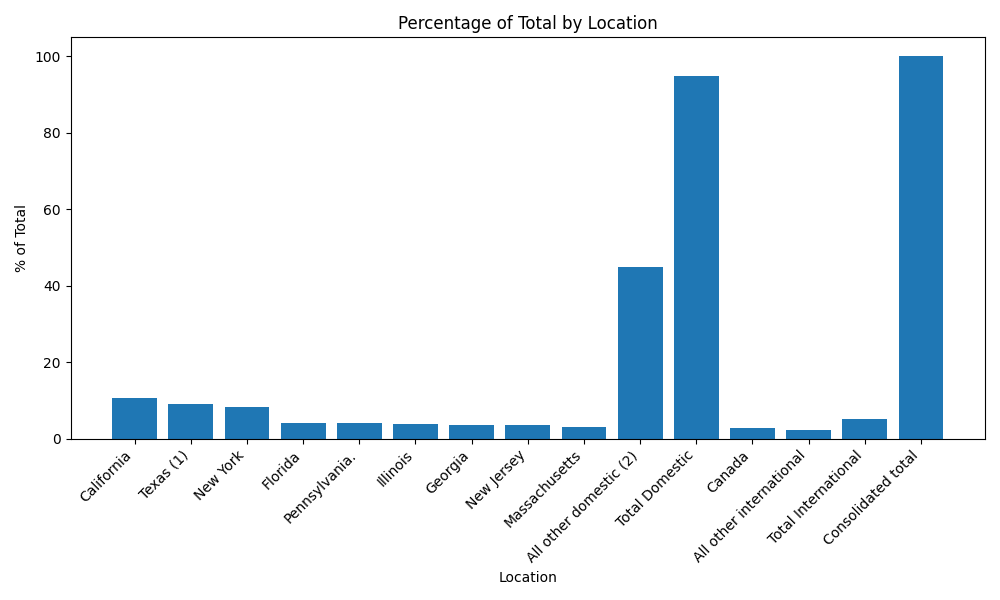

In [96]:
import base64
image_bytes = base64.b64decode(rc.candidates[0].content.parts[2].code_execution_result.output)
display(Image(data=image_bytes))